In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from pandas.api.types import is_numeric_dtype
from sklearn.metrics import precision_recall_curve
import catboost as cb
import gc
from sklearn.metrics import auc
import os

In [2]:
all_data = {}

In [18]:
# Obtaining directory of test datasets
d = '/Users/admin/BT4012/Project/Test'
test_files = os.listdir(d)
test_files = sorted(test_files)
test_files = [os.path.join(d, x) for x in test_files]
test_files

['/Users/admin/BT4012/Project/Test/test1.csv',
 '/Users/admin/BT4012/Project/Test/test2.csv',
 '/Users/admin/BT4012/Project/Test/test3.csv',
 '/Users/admin/BT4012/Project/Test/test4.csv',
 '/Users/admin/BT4012/Project/Test/test5.csv']

In [19]:
# Obtaining and storing directory of train datasets for robROSE 50-50
d = '/Users/admin/BT4012/Project/robROSE_50_50'
train_files =  os.listdir(d)
train_files = sorted(train_files)
train_files = [os.path.join(d, x) for x in train_files]
all_data['robROSE_50_50'] = train_files

In [20]:
# Obtaining and storing directory of train datasets for robROSE 60-40
d = '/Users/admin/BT4012/Project/robROSE_60_40'
train_files =  os.listdir(d)
train_files = sorted(train_files)
train_files = [os.path.join(d, x) for x in train_files]
all_data['robROSE_60_40'] = train_files

In [21]:
# Obtaining and storing directory of train datasets for robROSE 80-20
d = '/Users/admin/BT4012/Project/robROSE_80_20'
train_files =  os.listdir(d)
train_files = sorted(train_files)
train_files = [os.path.join(d, x) for x in train_files]
all_data['robROSE_80_20'] = train_files

In [22]:
# Obtaining and storing directory of train datasets for robROSE 99-1
d = '/Users/admin/BT4012/Project/robROSE_99_1'
train_files =  os.listdir(d)
train_files = sorted(train_files)
train_files = [os.path.join(d, x) for x in train_files]
all_data['robROSE_99_1'] = train_files

In [23]:
all_data

{'robROSE_50_50': ['/Users/admin/BT4012/Project/robROSE_50_50/robrose_50_50_1.csv',
  '/Users/admin/BT4012/Project/robROSE_50_50/robrose_50_50_2.csv',
  '/Users/admin/BT4012/Project/robROSE_50_50/robrose_50_50_3.csv',
  '/Users/admin/BT4012/Project/robROSE_50_50/robrose_50_50_4.csv',
  '/Users/admin/BT4012/Project/robROSE_50_50/robrose_50_50_5.csv'],
 'robROSE_60_40': ['/Users/admin/BT4012/Project/robROSE_60_40/robrose_60_40_1.csv',
  '/Users/admin/BT4012/Project/robROSE_60_40/robrose_60_40_2.csv',
  '/Users/admin/BT4012/Project/robROSE_60_40/robrose_60_40_3.csv',
  '/Users/admin/BT4012/Project/robROSE_60_40/robrose_60_40_4.csv',
  '/Users/admin/BT4012/Project/robROSE_60_40/robrose_60_40_5.csv'],
 'robROSE_80_20': ['/Users/admin/BT4012/Project/robROSE_80_20/robrose_80_20_1.csv',
  '/Users/admin/BT4012/Project/robROSE_80_20/robrose_80_20_2.csv',
  '/Users/admin/BT4012/Project/robROSE_80_20/robrose_80_20_3.csv',
  '/Users/admin/BT4012/Project/robROSE_80_20/robrose_80_20_4.csv',
  '/Users

## Basic Preprocessing Functions

## Getting categorical columns

In [24]:
def get_categorical_indices(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indices = []
    for col in cats:
        cat_indices.append(X.columns.get_loc(col))
    return cat_indices

## Preprocess the categorical features

1. Removing nulls 
2. Processing Categorical columns to "Category" data type

In [25]:
def process_cat(x_train):
    cats = []
    for col in x_train.columns:
        if is_numeric_dtype(x_train[col]):
            pass
        else:
            cats.append(col)
    for col in cats:
        x_train[col] = x_train[col].fillna('Nan')
        x_train[col] = x_train[col].astype('category')
        
    return x_train


In [26]:
def calculate_scores(y_test_proba, y_test):
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)

    auc_precision_recall = auc(recall, precision)
    roc_auc_score = metrics.roc_auc_score(y_test, y_test_proba)
    
#     print("Confusion Matrix: \n%s" % str(conf_matrix))
#     print("\nAccuracy: %.4f" % accuracy_score)
#     print("\nAU-PRC: %.4f" % auc_precision_recall)
#     print("\nAU-ROC: %.4f" % roc_auc_score)
#     print("\nF1 Score: %.4f" % f1_score)

    return {
        "roc_auc_score": roc_auc_score,
        "auc_precision_recall": auc_precision_recall,
    }

## Build Model and get scores

In [27]:
results = {}

In [28]:
# Looping through the different Sampling ratios
for method, dfs in all_data.items():
    print(method)
    print(dfs)

    total_auPRC = 0
    total_auROC = 0
    reports = []
    
    # Looping through the 5 fold training data
    for i in range(0, len(dfs)):
        print(i)
        # Reading data
        train = pd.read_csv(dfs[i], index_col = False)
        test = pd.read_csv(test_files[i], index_col = False)

        #drop irrelevant columns
        x_train = train.drop(['Unnamed: 0','Fraud'], axis = 1)
        y_train = train[['Fraud']]

        x_test = test.drop(['Unnamed: 0','Rndrng_NPI', 'Tot_Srvcs', 'Fraud'], axis = 1)
        y_test = test[['Fraud']]

        # process categorical data
        categorical_indices = get_categorical_indices(x_train)
        x_train = process_cat(x_train)
        x_test = process_cat(x_test)

        model = cb.CatBoostClassifier(task_type = 'CPU')
        model.fit(x_train, y_train, cat_features=categorical_indices)

        y_test_proba = model.predict_proba(x_test)[:, 1]

        #calculate auPRC
        precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
        auc_precision_recall = auc(recall, precision)
        total_auPRC+= auc_precision_recall

        #calculate auROC
        roc_auc_score = metrics.roc_auc_score(y_test, y_test_proba)
        total_auROC += roc_auc_score

        #add report to the ls of reports
        reports.append(calculate_scores(y_test_proba, y_test))
    
    mean_auPRC = total_auPRC/len(dfs)
    mean_auROC = total_auROC/len(dfs)
    
    print(mean_auPRC)
    print(mean_auROC)
    
    results[method] = (mean_auPRC, mean_auROC)

robROSE_50_50
['/Users/admin/BT4012/Project/robROSE_50_50/robrose_50_50_1.csv', '/Users/admin/BT4012/Project/robROSE_50_50/robrose_50_50_2.csv', '/Users/admin/BT4012/Project/robROSE_50_50/robrose_50_50_3.csv', '/Users/admin/BT4012/Project/robROSE_50_50/robrose_50_50_4.csv', '/Users/admin/BT4012/Project/robROSE_50_50/robrose_50_50_5.csv']
0
Learning rate set to 0.210613
0:	learn: 0.3185613	total: 1.12s	remaining: 18m 40s
1:	learn: 0.1896083	total: 1.77s	remaining: 14m 43s
2:	learn: 0.1272320	total: 2.44s	remaining: 13m 32s
3:	learn: 0.0633692	total: 3.27s	remaining: 13m 33s
4:	learn: 0.0395602	total: 3.95s	remaining: 13m 5s
5:	learn: 0.0296140	total: 4.59s	remaining: 12m 40s
6:	learn: 0.0245573	total: 5.31s	remaining: 12m 32s
7:	learn: 0.0201504	total: 6.37s	remaining: 13m 9s
8:	learn: 0.0188120	total: 7.19s	remaining: 13m 11s
9:	learn: 0.0179671	total: 7.94s	remaining: 13m 5s
10:	learn: 0.0175353	total: 8.67s	remaining: 12m 59s
11:	learn: 0.0169678	total: 9.7s	remaining: 13m 18s
12:	le

147:	learn: 0.0094438	total: 1m 40s	remaining: 9m 35s
148:	learn: 0.0094438	total: 1m 40s	remaining: 9m 33s
149:	learn: 0.0094438	total: 1m 40s	remaining: 9m 31s
150:	learn: 0.0094438	total: 1m 41s	remaining: 9m 29s
151:	learn: 0.0094438	total: 1m 41s	remaining: 9m 27s
152:	learn: 0.0094437	total: 1m 42s	remaining: 9m 25s
153:	learn: 0.0094437	total: 1m 42s	remaining: 9m 23s
154:	learn: 0.0094437	total: 1m 43s	remaining: 9m 21s
155:	learn: 0.0094437	total: 1m 43s	remaining: 9m 19s
156:	learn: 0.0094437	total: 1m 43s	remaining: 9m 18s
157:	learn: 0.0094437	total: 1m 44s	remaining: 9m 16s
158:	learn: 0.0094437	total: 1m 44s	remaining: 9m 14s
159:	learn: 0.0094437	total: 1m 45s	remaining: 9m 12s
160:	learn: 0.0094436	total: 1m 45s	remaining: 9m 10s
161:	learn: 0.0094436	total: 1m 46s	remaining: 9m 9s
162:	learn: 0.0094436	total: 1m 46s	remaining: 9m 7s
163:	learn: 0.0094436	total: 1m 47s	remaining: 9m 5s
164:	learn: 0.0094436	total: 1m 47s	remaining: 9m 3s
165:	learn: 0.0094436	total: 1m 

300:	learn: 0.0082838	total: 2m 54s	remaining: 6m 45s
301:	learn: 0.0082838	total: 2m 54s	remaining: 6m 44s
302:	learn: 0.0082838	total: 2m 55s	remaining: 6m 43s
303:	learn: 0.0082838	total: 2m 55s	remaining: 6m 42s
304:	learn: 0.0082838	total: 2m 56s	remaining: 6m 41s
305:	learn: 0.0082838	total: 2m 56s	remaining: 6m 40s
306:	learn: 0.0082838	total: 2m 57s	remaining: 6m 39s
307:	learn: 0.0082838	total: 2m 57s	remaining: 6m 39s
308:	learn: 0.0082838	total: 2m 58s	remaining: 6m 38s
309:	learn: 0.0082838	total: 2m 58s	remaining: 6m 37s
310:	learn: 0.0082838	total: 2m 58s	remaining: 6m 36s
311:	learn: 0.0082838	total: 2m 59s	remaining: 6m 35s
312:	learn: 0.0082838	total: 2m 59s	remaining: 6m 34s
313:	learn: 0.0082838	total: 3m	remaining: 6m 33s
314:	learn: 0.0082838	total: 3m	remaining: 6m 32s
315:	learn: 0.0082838	total: 3m	remaining: 6m 31s
316:	learn: 0.0082838	total: 3m 1s	remaining: 6m 30s
317:	learn: 0.0082838	total: 3m 1s	remaining: 6m 30s
318:	learn: 0.0082838	total: 3m 2s	remaini

453:	learn: 0.0082838	total: 3m 59s	remaining: 4m 48s
454:	learn: 0.0082838	total: 4m	remaining: 4m 47s
455:	learn: 0.0082838	total: 4m	remaining: 4m 47s
456:	learn: 0.0082838	total: 4m 1s	remaining: 4m 46s
457:	learn: 0.0082838	total: 4m 1s	remaining: 4m 45s
458:	learn: 0.0082838	total: 4m 1s	remaining: 4m 45s
459:	learn: 0.0082838	total: 4m 2s	remaining: 4m 44s
460:	learn: 0.0082838	total: 4m 2s	remaining: 4m 43s
461:	learn: 0.0082838	total: 4m 3s	remaining: 4m 43s
462:	learn: 0.0082838	total: 4m 3s	remaining: 4m 42s
463:	learn: 0.0082838	total: 4m 3s	remaining: 4m 41s
464:	learn: 0.0082838	total: 4m 4s	remaining: 4m 41s
465:	learn: 0.0082838	total: 4m 4s	remaining: 4m 40s
466:	learn: 0.0082838	total: 4m 5s	remaining: 4m 39s
467:	learn: 0.0082838	total: 4m 5s	remaining: 4m 39s
468:	learn: 0.0082838	total: 4m 6s	remaining: 4m 38s
469:	learn: 0.0082838	total: 4m 6s	remaining: 4m 37s
470:	learn: 0.0082838	total: 4m 6s	remaining: 4m 37s
471:	learn: 0.0082838	total: 4m 7s	remaining: 4m 36

606:	learn: 0.0082836	total: 5m 3s	remaining: 3m 16s
607:	learn: 0.0082835	total: 5m 4s	remaining: 3m 16s
608:	learn: 0.0082835	total: 5m 4s	remaining: 3m 15s
609:	learn: 0.0082835	total: 5m 5s	remaining: 3m 15s
610:	learn: 0.0082835	total: 5m 5s	remaining: 3m 14s
611:	learn: 0.0082834	total: 5m 5s	remaining: 3m 13s
612:	learn: 0.0082834	total: 5m 6s	remaining: 3m 13s
613:	learn: 0.0082834	total: 5m 6s	remaining: 3m 12s
614:	learn: 0.0082834	total: 5m 7s	remaining: 3m 12s
615:	learn: 0.0082834	total: 5m 7s	remaining: 3m 11s
616:	learn: 0.0082834	total: 5m 8s	remaining: 3m 11s
617:	learn: 0.0082834	total: 5m 8s	remaining: 3m 10s
618:	learn: 0.0082834	total: 5m 9s	remaining: 3m 10s
619:	learn: 0.0082834	total: 5m 9s	remaining: 3m 9s
620:	learn: 0.0082834	total: 5m 9s	remaining: 3m 9s
621:	learn: 0.0082834	total: 5m 10s	remaining: 3m 8s
622:	learn: 0.0082834	total: 5m 10s	remaining: 3m 8s
623:	learn: 0.0082834	total: 5m 11s	remaining: 3m 7s
624:	learn: 0.0082834	total: 5m 11s	remaining: 3

760:	learn: 0.0082825	total: 6m 9s	remaining: 1m 56s
761:	learn: 0.0082825	total: 6m 10s	remaining: 1m 55s
762:	learn: 0.0082825	total: 6m 10s	remaining: 1m 55s
763:	learn: 0.0082825	total: 6m 11s	remaining: 1m 54s
764:	learn: 0.0082825	total: 6m 11s	remaining: 1m 54s
765:	learn: 0.0082825	total: 6m 11s	remaining: 1m 53s
766:	learn: 0.0082825	total: 6m 12s	remaining: 1m 53s
767:	learn: 0.0082825	total: 6m 12s	remaining: 1m 52s
768:	learn: 0.0082825	total: 6m 13s	remaining: 1m 52s
769:	learn: 0.0082825	total: 6m 13s	remaining: 1m 51s
770:	learn: 0.0082825	total: 6m 13s	remaining: 1m 51s
771:	learn: 0.0082825	total: 6m 14s	remaining: 1m 50s
772:	learn: 0.0082825	total: 6m 14s	remaining: 1m 50s
773:	learn: 0.0082825	total: 6m 15s	remaining: 1m 49s
774:	learn: 0.0082825	total: 6m 15s	remaining: 1m 49s
775:	learn: 0.0082825	total: 6m 15s	remaining: 1m 48s
776:	learn: 0.0082825	total: 6m 16s	remaining: 1m 48s
777:	learn: 0.0082825	total: 6m 16s	remaining: 1m 47s
778:	learn: 0.0082825	total: 

914:	learn: 0.0082140	total: 7m 15s	remaining: 40.4s
915:	learn: 0.0082140	total: 7m 15s	remaining: 40s
916:	learn: 0.0082140	total: 7m 16s	remaining: 39.5s
917:	learn: 0.0082140	total: 7m 16s	remaining: 39s
918:	learn: 0.0082140	total: 7m 16s	remaining: 38.5s
919:	learn: 0.0082140	total: 7m 17s	remaining: 38s
920:	learn: 0.0082139	total: 7m 17s	remaining: 37.6s
921:	learn: 0.0082139	total: 7m 18s	remaining: 37.1s
922:	learn: 0.0082139	total: 7m 18s	remaining: 36.6s
923:	learn: 0.0082139	total: 7m 19s	remaining: 36.1s
924:	learn: 0.0082139	total: 7m 19s	remaining: 35.6s
925:	learn: 0.0082139	total: 7m 19s	remaining: 35.2s
926:	learn: 0.0082139	total: 7m 20s	remaining: 34.7s
927:	learn: 0.0082139	total: 7m 20s	remaining: 34.2s
928:	learn: 0.0082139	total: 7m 21s	remaining: 33.7s
929:	learn: 0.0082139	total: 7m 21s	remaining: 33.2s
930:	learn: 0.0082139	total: 7m 21s	remaining: 32.8s
931:	learn: 0.0082138	total: 7m 22s	remaining: 32.3s
932:	learn: 0.0082138	total: 7m 22s	remaining: 31.8s

69:	learn: 0.0096254	total: 50.9s	remaining: 11m 16s
70:	learn: 0.0095796	total: 51.6s	remaining: 11m 14s
71:	learn: 0.0095267	total: 52.3s	remaining: 11m 14s
72:	learn: 0.0095266	total: 52.9s	remaining: 11m 11s
73:	learn: 0.0094853	total: 53.6s	remaining: 11m 10s
74:	learn: 0.0094685	total: 54.2s	remaining: 11m 8s
75:	learn: 0.0094684	total: 54.8s	remaining: 11m 6s
76:	learn: 0.0094203	total: 55.5s	remaining: 11m 5s
77:	learn: 0.0094203	total: 56s	remaining: 11m 1s
78:	learn: 0.0094203	total: 56.4s	remaining: 10m 58s
79:	learn: 0.0094203	total: 57.1s	remaining: 10m 56s
80:	learn: 0.0094203	total: 57.6s	remaining: 10m 53s
81:	learn: 0.0094203	total: 58.1s	remaining: 10m 50s
82:	learn: 0.0094202	total: 58.7s	remaining: 10m 48s
83:	learn: 0.0094202	total: 59.3s	remaining: 10m 46s
84:	learn: 0.0094202	total: 59.9s	remaining: 10m 44s
85:	learn: 0.0094202	total: 1m	remaining: 10m 43s
86:	learn: 0.0094202	total: 1m 1s	remaining: 10m 40s
87:	learn: 0.0094201	total: 1m 1s	remaining: 10m 37s
88

223:	learn: 0.0094101	total: 1m 59s	remaining: 6m 52s
224:	learn: 0.0094101	total: 1m 59s	remaining: 6m 51s
225:	learn: 0.0094101	total: 1m 59s	remaining: 6m 50s
226:	learn: 0.0094101	total: 2m	remaining: 6m 49s
227:	learn: 0.0094101	total: 2m	remaining: 6m 49s
228:	learn: 0.0094101	total: 2m 1s	remaining: 6m 48s
229:	learn: 0.0094101	total: 2m 1s	remaining: 6m 47s
230:	learn: 0.0094101	total: 2m 2s	remaining: 6m 46s
231:	learn: 0.0094101	total: 2m 2s	remaining: 6m 45s
232:	learn: 0.0094101	total: 2m 2s	remaining: 6m 44s
233:	learn: 0.0094101	total: 2m 3s	remaining: 6m 43s
234:	learn: 0.0094101	total: 2m 3s	remaining: 6m 43s
235:	learn: 0.0094101	total: 2m 4s	remaining: 6m 42s
236:	learn: 0.0094101	total: 2m 4s	remaining: 6m 41s
237:	learn: 0.0094101	total: 2m 5s	remaining: 6m 40s
238:	learn: 0.0094101	total: 2m 5s	remaining: 6m 39s
239:	learn: 0.0094101	total: 2m 5s	remaining: 6m 38s
240:	learn: 0.0094101	total: 2m 6s	remaining: 6m 38s
241:	learn: 0.0094101	total: 2m 6s	remaining: 6m 

377:	learn: 0.0094101	total: 3m 4s	remaining: 5m 4s
378:	learn: 0.0093366	total: 3m 5s	remaining: 5m 3s
379:	learn: 0.0093366	total: 3m 6s	remaining: 5m 3s
380:	learn: 0.0093366	total: 3m 6s	remaining: 5m 3s
381:	learn: 0.0093366	total: 3m 6s	remaining: 5m 2s
382:	learn: 0.0093365	total: 3m 7s	remaining: 5m 2s
383:	learn: 0.0093365	total: 3m 7s	remaining: 5m 1s
384:	learn: 0.0093365	total: 3m 8s	remaining: 5m
385:	learn: 0.0092056	total: 3m 9s	remaining: 5m
386:	learn: 0.0091220	total: 3m 9s	remaining: 5m
387:	learn: 0.0090661	total: 3m 10s	remaining: 5m
388:	learn: 0.0090190	total: 3m 11s	remaining: 5m 1s
389:	learn: 0.0090189	total: 3m 12s	remaining: 5m
390:	learn: 0.0090189	total: 3m 12s	remaining: 5m
391:	learn: 0.0090189	total: 3m 13s	remaining: 4m 59s
392:	learn: 0.0090189	total: 3m 13s	remaining: 4m 59s
393:	learn: 0.0090189	total: 3m 14s	remaining: 4m 58s
394:	learn: 0.0090189	total: 3m 14s	remaining: 4m 57s
395:	learn: 0.0090189	total: 3m 14s	remaining: 4m 57s
396:	learn: 0.00

531:	learn: 0.0089177	total: 4m 13s	remaining: 3m 42s
532:	learn: 0.0089177	total: 4m 13s	remaining: 3m 42s
533:	learn: 0.0089177	total: 4m 13s	remaining: 3m 41s
534:	learn: 0.0089176	total: 4m 14s	remaining: 3m 41s
535:	learn: 0.0089176	total: 4m 14s	remaining: 3m 40s
536:	learn: 0.0089176	total: 4m 15s	remaining: 3m 40s
537:	learn: 0.0089176	total: 4m 15s	remaining: 3m 39s
538:	learn: 0.0089176	total: 4m 15s	remaining: 3m 38s
539:	learn: 0.0089176	total: 4m 16s	remaining: 3m 38s
540:	learn: 0.0089176	total: 4m 16s	remaining: 3m 37s
541:	learn: 0.0089175	total: 4m 17s	remaining: 3m 37s
542:	learn: 0.0089175	total: 4m 17s	remaining: 3m 36s
543:	learn: 0.0089175	total: 4m 18s	remaining: 3m 36s
544:	learn: 0.0089175	total: 4m 18s	remaining: 3m 35s
545:	learn: 0.0089175	total: 4m 18s	remaining: 3m 35s
546:	learn: 0.0089175	total: 4m 19s	remaining: 3m 34s
547:	learn: 0.0089174	total: 4m 19s	remaining: 3m 34s
548:	learn: 0.0089174	total: 4m 20s	remaining: 3m 33s
549:	learn: 0.0089173	total:

684:	learn: 0.0089161	total: 5m 17s	remaining: 2m 26s
685:	learn: 0.0089161	total: 5m 18s	remaining: 2m 25s
686:	learn: 0.0089161	total: 5m 18s	remaining: 2m 25s
687:	learn: 0.0089160	total: 5m 19s	remaining: 2m 24s
688:	learn: 0.0089160	total: 5m 19s	remaining: 2m 24s
689:	learn: 0.0089160	total: 5m 20s	remaining: 2m 23s
690:	learn: 0.0089160	total: 5m 20s	remaining: 2m 23s
691:	learn: 0.0089160	total: 5m 21s	remaining: 2m 22s
692:	learn: 0.0089159	total: 5m 21s	remaining: 2m 22s
693:	learn: 0.0089159	total: 5m 22s	remaining: 2m 21s
694:	learn: 0.0089158	total: 5m 22s	remaining: 2m 21s
695:	learn: 0.0089158	total: 5m 22s	remaining: 2m 21s
696:	learn: 0.0089158	total: 5m 23s	remaining: 2m 20s
697:	learn: 0.0089158	total: 5m 23s	remaining: 2m 20s
698:	learn: 0.0089158	total: 5m 24s	remaining: 2m 19s
699:	learn: 0.0089158	total: 5m 24s	remaining: 2m 19s
700:	learn: 0.0089158	total: 5m 24s	remaining: 2m 18s
701:	learn: 0.0089157	total: 5m 25s	remaining: 2m 18s
702:	learn: 0.0089157	total:

837:	learn: 0.0087820	total: 6m 24s	remaining: 1m 14s
838:	learn: 0.0087819	total: 6m 25s	remaining: 1m 13s
839:	learn: 0.0087819	total: 6m 25s	remaining: 1m 13s
840:	learn: 0.0087819	total: 6m 26s	remaining: 1m 13s
841:	learn: 0.0087819	total: 6m 26s	remaining: 1m 12s
842:	learn: 0.0087819	total: 6m 27s	remaining: 1m 12s
843:	learn: 0.0087819	total: 6m 27s	remaining: 1m 11s
844:	learn: 0.0087819	total: 6m 27s	remaining: 1m 11s
845:	learn: 0.0087818	total: 6m 28s	remaining: 1m 10s
846:	learn: 0.0087818	total: 6m 28s	remaining: 1m 10s
847:	learn: 0.0087818	total: 6m 29s	remaining: 1m 9s
848:	learn: 0.0087818	total: 6m 29s	remaining: 1m 9s
849:	learn: 0.0087818	total: 6m 29s	remaining: 1m 8s
850:	learn: 0.0087818	total: 6m 30s	remaining: 1m 8s
851:	learn: 0.0087818	total: 6m 30s	remaining: 1m 7s
852:	learn: 0.0087818	total: 6m 31s	remaining: 1m 7s
853:	learn: 0.0087818	total: 6m 31s	remaining: 1m 6s
854:	learn: 0.0087818	total: 6m 32s	remaining: 1m 6s
855:	learn: 0.0087818	total: 6m 32s	

993:	learn: 0.0087799	total: 7m 31s	remaining: 2.72s
994:	learn: 0.0087799	total: 7m 31s	remaining: 2.27s
995:	learn: 0.0087799	total: 7m 32s	remaining: 1.81s
996:	learn: 0.0087799	total: 7m 32s	remaining: 1.36s
997:	learn: 0.0087799	total: 7m 33s	remaining: 908ms
998:	learn: 0.0087799	total: 7m 33s	remaining: 454ms
999:	learn: 0.0087799	total: 7m 33s	remaining: 0us
2
Learning rate set to 0.21059
0:	learn: 0.3060234	total: 910ms	remaining: 15m 9s
1:	learn: 0.1845805	total: 1.64s	remaining: 13m 36s
2:	learn: 0.1220768	total: 2.34s	remaining: 12m 57s
3:	learn: 0.0609620	total: 3.11s	remaining: 12m 55s
4:	learn: 0.0391035	total: 3.73s	remaining: 12m 23s
5:	learn: 0.0298162	total: 4.39s	remaining: 12m 7s
6:	learn: 0.0244119	total: 5.02s	remaining: 11m 51s
7:	learn: 0.0210227	total: 5.64s	remaining: 11m 39s
8:	learn: 0.0194339	total: 6.5s	remaining: 11m 55s
9:	learn: 0.0180174	total: 7.14s	remaining: 11m 46s
10:	learn: 0.0169938	total: 7.62s	remaining: 11m 25s
11:	learn: 0.0162514	total: 8.

148:	learn: 0.0092976	total: 1m 24s	remaining: 8m 3s
149:	learn: 0.0092975	total: 1m 24s	remaining: 8m 1s
150:	learn: 0.0092975	total: 1m 25s	remaining: 8m
151:	learn: 0.0092975	total: 1m 25s	remaining: 7m 58s
152:	learn: 0.0092974	total: 1m 26s	remaining: 7m 57s
153:	learn: 0.0092533	total: 1m 27s	remaining: 7m 58s
154:	learn: 0.0092533	total: 1m 27s	remaining: 7m 56s
155:	learn: 0.0092533	total: 1m 27s	remaining: 7m 55s
156:	learn: 0.0092532	total: 1m 28s	remaining: 7m 54s
157:	learn: 0.0092532	total: 1m 28s	remaining: 7m 52s
158:	learn: 0.0092531	total: 1m 29s	remaining: 7m 51s
159:	learn: 0.0092531	total: 1m 29s	remaining: 7m 50s
160:	learn: 0.0092531	total: 1m 29s	remaining: 7m 48s
161:	learn: 0.0092531	total: 1m 30s	remaining: 7m 47s
162:	learn: 0.0092531	total: 1m 30s	remaining: 7m 46s
163:	learn: 0.0092530	total: 1m 31s	remaining: 7m 45s
164:	learn: 0.0092530	total: 1m 31s	remaining: 7m 44s
165:	learn: 0.0092530	total: 1m 32s	remaining: 7m 42s
166:	learn: 0.0092529	total: 1m 32

302:	learn: 0.0088122	total: 2m 33s	remaining: 5m 52s
303:	learn: 0.0088121	total: 2m 33s	remaining: 5m 52s
304:	learn: 0.0088121	total: 2m 34s	remaining: 5m 51s
305:	learn: 0.0088121	total: 2m 34s	remaining: 5m 50s
306:	learn: 0.0088121	total: 2m 35s	remaining: 5m 49s
307:	learn: 0.0088121	total: 2m 35s	remaining: 5m 49s
308:	learn: 0.0088119	total: 2m 35s	remaining: 5m 48s
309:	learn: 0.0088118	total: 2m 36s	remaining: 5m 47s
310:	learn: 0.0088118	total: 2m 36s	remaining: 5m 47s
311:	learn: 0.0088118	total: 2m 37s	remaining: 5m 46s
312:	learn: 0.0088117	total: 2m 37s	remaining: 5m 46s
313:	learn: 0.0088117	total: 2m 38s	remaining: 5m 45s
314:	learn: 0.0088117	total: 2m 38s	remaining: 5m 44s
315:	learn: 0.0088117	total: 2m 38s	remaining: 5m 43s
316:	learn: 0.0088117	total: 2m 39s	remaining: 5m 42s
317:	learn: 0.0088117	total: 2m 39s	remaining: 5m 42s
318:	learn: 0.0088116	total: 2m 39s	remaining: 5m 41s
319:	learn: 0.0088116	total: 2m 40s	remaining: 5m 40s
320:	learn: 0.0088116	total:

455:	learn: 0.0080736	total: 3m 43s	remaining: 4m 26s
456:	learn: 0.0080735	total: 3m 44s	remaining: 4m 26s
457:	learn: 0.0080735	total: 3m 44s	remaining: 4m 25s
458:	learn: 0.0080735	total: 3m 44s	remaining: 4m 25s
459:	learn: 0.0080735	total: 3m 45s	remaining: 4m 24s
460:	learn: 0.0080735	total: 3m 45s	remaining: 4m 23s
461:	learn: 0.0080735	total: 3m 46s	remaining: 4m 23s
462:	learn: 0.0080735	total: 3m 46s	remaining: 4m 22s
463:	learn: 0.0080735	total: 3m 46s	remaining: 4m 22s
464:	learn: 0.0080735	total: 3m 47s	remaining: 4m 21s
465:	learn: 0.0080735	total: 3m 47s	remaining: 4m 21s
466:	learn: 0.0080735	total: 3m 48s	remaining: 4m 20s
467:	learn: 0.0080735	total: 3m 48s	remaining: 4m 19s
468:	learn: 0.0080735	total: 3m 49s	remaining: 4m 19s
469:	learn: 0.0080735	total: 3m 49s	remaining: 4m 18s
470:	learn: 0.0080735	total: 3m 49s	remaining: 4m 18s
471:	learn: 0.0080735	total: 3m 50s	remaining: 4m 17s
472:	learn: 0.0080735	total: 3m 50s	remaining: 4m 17s
473:	learn: 0.0080735	total:

608:	learn: 0.0079348	total: 4m 49s	remaining: 3m 6s
609:	learn: 0.0079348	total: 4m 50s	remaining: 3m 5s
610:	learn: 0.0079348	total: 4m 50s	remaining: 3m 5s
611:	learn: 0.0079348	total: 4m 51s	remaining: 3m 4s
612:	learn: 0.0079348	total: 4m 51s	remaining: 3m 4s
613:	learn: 0.0079348	total: 4m 52s	remaining: 3m 3s
614:	learn: 0.0079348	total: 4m 52s	remaining: 3m 3s
615:	learn: 0.0079348	total: 4m 52s	remaining: 3m 2s
616:	learn: 0.0079348	total: 4m 53s	remaining: 3m 2s
617:	learn: 0.0079348	total: 4m 53s	remaining: 3m 1s
618:	learn: 0.0079348	total: 4m 54s	remaining: 3m 1s
619:	learn: 0.0079348	total: 4m 54s	remaining: 3m
620:	learn: 0.0079348	total: 4m 55s	remaining: 3m
621:	learn: 0.0079348	total: 4m 55s	remaining: 2m 59s
622:	learn: 0.0079348	total: 4m 55s	remaining: 2m 59s
623:	learn: 0.0079348	total: 4m 56s	remaining: 2m 58s
624:	learn: 0.0079348	total: 4m 56s	remaining: 2m 58s
625:	learn: 0.0079348	total: 4m 57s	remaining: 2m 57s
626:	learn: 0.0079348	total: 4m 58s	remaining: 

762:	learn: 0.0079151	total: 5m 55s	remaining: 1m 50s
763:	learn: 0.0079151	total: 5m 55s	remaining: 1m 49s
764:	learn: 0.0079151	total: 5m 56s	remaining: 1m 49s
765:	learn: 0.0079151	total: 5m 56s	remaining: 1m 48s
766:	learn: 0.0079151	total: 5m 57s	remaining: 1m 48s
767:	learn: 0.0079151	total: 5m 57s	remaining: 1m 48s
768:	learn: 0.0079151	total: 5m 57s	remaining: 1m 47s
769:	learn: 0.0079150	total: 5m 58s	remaining: 1m 47s
770:	learn: 0.0079150	total: 5m 58s	remaining: 1m 46s
771:	learn: 0.0079150	total: 5m 59s	remaining: 1m 46s
772:	learn: 0.0079150	total: 5m 59s	remaining: 1m 45s
773:	learn: 0.0079150	total: 5m 59s	remaining: 1m 45s
774:	learn: 0.0079150	total: 6m	remaining: 1m 44s
775:	learn: 0.0079150	total: 6m	remaining: 1m 44s
776:	learn: 0.0079150	total: 6m 1s	remaining: 1m 43s
777:	learn: 0.0079150	total: 6m 1s	remaining: 1m 43s
778:	learn: 0.0079150	total: 6m 1s	remaining: 1m 42s
779:	learn: 0.0079150	total: 6m 2s	remaining: 1m 42s
780:	learn: 0.0079150	total: 6m 2s	remai

916:	learn: 0.0078760	total: 6m 59s	remaining: 38s
917:	learn: 0.0078760	total: 7m	remaining: 37.5s
918:	learn: 0.0078760	total: 7m	remaining: 37.1s
919:	learn: 0.0078760	total: 7m 1s	remaining: 36.6s
920:	learn: 0.0078760	total: 7m 1s	remaining: 36.1s
921:	learn: 0.0078760	total: 7m 1s	remaining: 35.7s
922:	learn: 0.0078760	total: 7m 2s	remaining: 35.2s
923:	learn: 0.0078760	total: 7m 2s	remaining: 34.8s
924:	learn: 0.0078760	total: 7m 3s	remaining: 34.3s
925:	learn: 0.0078760	total: 7m 3s	remaining: 33.9s
926:	learn: 0.0078760	total: 7m 3s	remaining: 33.4s
927:	learn: 0.0078760	total: 7m 4s	remaining: 32.9s
928:	learn: 0.0078760	total: 7m 4s	remaining: 32.5s
929:	learn: 0.0078760	total: 7m 5s	remaining: 32s
930:	learn: 0.0078760	total: 7m 5s	remaining: 31.5s
931:	learn: 0.0078760	total: 7m 5s	remaining: 31.1s
932:	learn: 0.0078760	total: 7m 6s	remaining: 30.6s
933:	learn: 0.0078760	total: 7m 6s	remaining: 30.1s
934:	learn: 0.0078760	total: 7m 7s	remaining: 29.7s
935:	learn: 0.0078760

72:	learn: 0.0094950	total: 51.4s	remaining: 10m 52s
73:	learn: 0.0094272	total: 52.1s	remaining: 10m 51s
74:	learn: 0.0093333	total: 52.8s	remaining: 10m 50s
75:	learn: 0.0092789	total: 53.5s	remaining: 10m 49s
76:	learn: 0.0092789	total: 54s	remaining: 10m 47s
77:	learn: 0.0092301	total: 54.8s	remaining: 10m 48s
78:	learn: 0.0092301	total: 55.5s	remaining: 10m 46s
79:	learn: 0.0091960	total: 56.2s	remaining: 10m 46s
80:	learn: 0.0091548	total: 57s	remaining: 10m 46s
81:	learn: 0.0091548	total: 57.5s	remaining: 10m 43s
82:	learn: 0.0091546	total: 57.9s	remaining: 10m 39s
83:	learn: 0.0091546	total: 58.3s	remaining: 10m 35s
84:	learn: 0.0091546	total: 58.8s	remaining: 10m 32s
85:	learn: 0.0091546	total: 59.3s	remaining: 10m 30s
86:	learn: 0.0091425	total: 59.8s	remaining: 10m 27s
87:	learn: 0.0090991	total: 1m	remaining: 10m 26s
88:	learn: 0.0090359	total: 1m 1s	remaining: 10m 26s
89:	learn: 0.0089931	total: 1m 2s	remaining: 10m 27s
90:	learn: 0.0089931	total: 1m 2s	remaining: 10m 23s


226:	learn: 0.0081529	total: 2m 4s	remaining: 7m 2s
227:	learn: 0.0081529	total: 2m 4s	remaining: 7m 1s
228:	learn: 0.0081529	total: 2m 4s	remaining: 7m
229:	learn: 0.0081529	total: 2m 5s	remaining: 6m 59s
230:	learn: 0.0081529	total: 2m 5s	remaining: 6m 58s
231:	learn: 0.0081529	total: 2m 6s	remaining: 6m 57s
232:	learn: 0.0081528	total: 2m 6s	remaining: 6m 56s
233:	learn: 0.0081528	total: 2m 6s	remaining: 6m 55s
234:	learn: 0.0081528	total: 2m 7s	remaining: 6m 54s
235:	learn: 0.0081528	total: 2m 7s	remaining: 6m 53s
236:	learn: 0.0081528	total: 2m 8s	remaining: 6m 52s
237:	learn: 0.0081528	total: 2m 8s	remaining: 6m 51s
238:	learn: 0.0081527	total: 2m 9s	remaining: 6m 50s
239:	learn: 0.0081076	total: 2m 9s	remaining: 6m 50s
240:	learn: 0.0081076	total: 2m 10s	remaining: 6m 49s
241:	learn: 0.0081076	total: 2m 10s	remaining: 6m 48s
242:	learn: 0.0081076	total: 2m 10s	remaining: 6m 48s
243:	learn: 0.0081076	total: 2m 11s	remaining: 6m 47s
244:	learn: 0.0080749	total: 2m 12s	remaining: 6

380:	learn: 0.0079821	total: 3m 10s	remaining: 5m 8s
381:	learn: 0.0079820	total: 3m 10s	remaining: 5m 8s
382:	learn: 0.0079820	total: 3m 10s	remaining: 5m 7s
383:	learn: 0.0079820	total: 3m 11s	remaining: 5m 6s
384:	learn: 0.0079820	total: 3m 11s	remaining: 5m 6s
385:	learn: 0.0079820	total: 3m 12s	remaining: 5m 5s
386:	learn: 0.0079819	total: 3m 12s	remaining: 5m 5s
387:	learn: 0.0079819	total: 3m 12s	remaining: 5m 4s
388:	learn: 0.0079819	total: 3m 13s	remaining: 5m 3s
389:	learn: 0.0079818	total: 3m 13s	remaining: 5m 3s
390:	learn: 0.0079818	total: 3m 14s	remaining: 5m 2s
391:	learn: 0.0079818	total: 3m 14s	remaining: 5m 1s
392:	learn: 0.0079818	total: 3m 15s	remaining: 5m 1s
393:	learn: 0.0079818	total: 3m 15s	remaining: 5m
394:	learn: 0.0079818	total: 3m 15s	remaining: 5m
395:	learn: 0.0079817	total: 3m 16s	remaining: 4m 59s
396:	learn: 0.0079817	total: 3m 16s	remaining: 4m 58s
397:	learn: 0.0079511	total: 3m 17s	remaining: 4m 58s
398:	learn: 0.0079108	total: 3m 18s	remaining: 4m

534:	learn: 0.0072819	total: 4m 20s	remaining: 3m 46s
535:	learn: 0.0072819	total: 4m 20s	remaining: 3m 45s
536:	learn: 0.0072818	total: 4m 21s	remaining: 3m 45s
537:	learn: 0.0072818	total: 4m 21s	remaining: 3m 44s
538:	learn: 0.0072818	total: 4m 22s	remaining: 3m 44s
539:	learn: 0.0072818	total: 4m 22s	remaining: 3m 43s
540:	learn: 0.0072818	total: 4m 22s	remaining: 3m 43s
541:	learn: 0.0072818	total: 4m 23s	remaining: 3m 42s
542:	learn: 0.0072818	total: 4m 23s	remaining: 3m 42s
543:	learn: 0.0072818	total: 4m 24s	remaining: 3m 41s
544:	learn: 0.0072818	total: 4m 24s	remaining: 3m 40s
545:	learn: 0.0072817	total: 4m 25s	remaining: 3m 40s
546:	learn: 0.0072817	total: 4m 25s	remaining: 3m 39s
547:	learn: 0.0072817	total: 4m 25s	remaining: 3m 39s
548:	learn: 0.0072817	total: 4m 26s	remaining: 3m 38s
549:	learn: 0.0072817	total: 4m 26s	remaining: 3m 38s
550:	learn: 0.0072817	total: 4m 27s	remaining: 3m 37s
551:	learn: 0.0072817	total: 4m 27s	remaining: 3m 37s
552:	learn: 0.0072817	total:

687:	learn: 0.0071901	total: 5m 25s	remaining: 2m 27s
688:	learn: 0.0071901	total: 5m 25s	remaining: 2m 27s
689:	learn: 0.0071901	total: 5m 26s	remaining: 2m 26s
690:	learn: 0.0071901	total: 5m 26s	remaining: 2m 26s
691:	learn: 0.0071900	total: 5m 26s	remaining: 2m 25s
692:	learn: 0.0071900	total: 5m 27s	remaining: 2m 25s
693:	learn: 0.0071900	total: 5m 27s	remaining: 2m 24s
694:	learn: 0.0071899	total: 5m 28s	remaining: 2m 24s
695:	learn: 0.0071899	total: 5m 28s	remaining: 2m 23s
696:	learn: 0.0071899	total: 5m 29s	remaining: 2m 23s
697:	learn: 0.0071899	total: 5m 29s	remaining: 2m 22s
698:	learn: 0.0071899	total: 5m 29s	remaining: 2m 22s
699:	learn: 0.0071899	total: 5m 30s	remaining: 2m 21s
700:	learn: 0.0071899	total: 5m 30s	remaining: 2m 21s
701:	learn: 0.0071899	total: 5m 31s	remaining: 2m 20s
702:	learn: 0.0071899	total: 5m 31s	remaining: 2m 20s
703:	learn: 0.0071899	total: 5m 31s	remaining: 2m 19s
704:	learn: 0.0071898	total: 5m 32s	remaining: 2m 19s
705:	learn: 0.0071898	total:

840:	learn: 0.0070858	total: 6m 28s	remaining: 1m 13s
841:	learn: 0.0070518	total: 6m 29s	remaining: 1m 13s
842:	learn: 0.0070517	total: 6m 29s	remaining: 1m 12s
843:	learn: 0.0070517	total: 6m 30s	remaining: 1m 12s
844:	learn: 0.0070132	total: 6m 30s	remaining: 1m 11s
845:	learn: 0.0069948	total: 6m 31s	remaining: 1m 11s
846:	learn: 0.0069948	total: 6m 31s	remaining: 1m 10s
847:	learn: 0.0069948	total: 6m 32s	remaining: 1m 10s
848:	learn: 0.0069948	total: 6m 32s	remaining: 1m 9s
849:	learn: 0.0069948	total: 6m 33s	remaining: 1m 9s
850:	learn: 0.0069658	total: 6m 33s	remaining: 1m 8s
851:	learn: 0.0069658	total: 6m 34s	remaining: 1m 8s
852:	learn: 0.0069658	total: 6m 34s	remaining: 1m 8s
853:	learn: 0.0069658	total: 6m 35s	remaining: 1m 7s
854:	learn: 0.0069658	total: 6m 35s	remaining: 1m 7s
855:	learn: 0.0069466	total: 6m 36s	remaining: 1m 6s
856:	learn: 0.0069466	total: 6m 36s	remaining: 1m 6s
857:	learn: 0.0069466	total: 6m 36s	remaining: 1m 5s
858:	learn: 0.0069466	total: 6m 37s	re

996:	learn: 0.0068735	total: 7m 32s	remaining: 1.36s
997:	learn: 0.0068735	total: 7m 32s	remaining: 908ms
998:	learn: 0.0068735	total: 7m 33s	remaining: 454ms
999:	learn: 0.0068735	total: 7m 33s	remaining: 0us
4
Learning rate set to 0.21061
0:	learn: 0.3161295	total: 850ms	remaining: 14m 8s
1:	learn: 0.1900046	total: 1.52s	remaining: 12m 37s
2:	learn: 0.1308945	total: 2.2s	remaining: 12m 10s
3:	learn: 0.0653052	total: 2.83s	remaining: 11m 45s
4:	learn: 0.0368867	total: 3.39s	remaining: 11m 15s
5:	learn: 0.0272728	total: 4.01s	remaining: 11m 3s
6:	learn: 0.0228281	total: 4.6s	remaining: 10m 52s
7:	learn: 0.0202482	total: 5.15s	remaining: 10m 38s
8:	learn: 0.0180021	total: 5.77s	remaining: 10m 35s
9:	learn: 0.0170911	total: 6.34s	remaining: 10m 27s
10:	learn: 0.0166295	total: 7s	remaining: 10m 29s
11:	learn: 0.0158947	total: 7.62s	remaining: 10m 27s
12:	learn: 0.0155987	total: 8.26s	remaining: 10m 27s
13:	learn: 0.0152614	total: 8.9s	remaining: 10m 26s
14:	learn: 0.0147999	total: 9.61s	r

152:	learn: 0.0091050	total: 1m 22s	remaining: 7m 35s
153:	learn: 0.0091050	total: 1m 22s	remaining: 7m 33s
154:	learn: 0.0091050	total: 1m 22s	remaining: 7m 32s
155:	learn: 0.0091050	total: 1m 23s	remaining: 7m 30s
156:	learn: 0.0091049	total: 1m 23s	remaining: 7m 29s
157:	learn: 0.0091049	total: 1m 24s	remaining: 7m 28s
158:	learn: 0.0091049	total: 1m 24s	remaining: 7m 26s
159:	learn: 0.0091049	total: 1m 24s	remaining: 7m 25s
160:	learn: 0.0091049	total: 1m 25s	remaining: 7m 23s
161:	learn: 0.0091049	total: 1m 25s	remaining: 7m 22s
162:	learn: 0.0091049	total: 1m 25s	remaining: 7m 21s
163:	learn: 0.0091049	total: 1m 26s	remaining: 7m 19s
164:	learn: 0.0091049	total: 1m 26s	remaining: 7m 18s
165:	learn: 0.0091049	total: 1m 27s	remaining: 7m 17s
166:	learn: 0.0091049	total: 1m 27s	remaining: 7m 15s
167:	learn: 0.0091049	total: 1m 27s	remaining: 7m 14s
168:	learn: 0.0091049	total: 1m 28s	remaining: 7m 13s
169:	learn: 0.0091049	total: 1m 28s	remaining: 7m 12s
170:	learn: 0.0091049	total:

305:	learn: 0.0089869	total: 2m 20s	remaining: 5m 19s
306:	learn: 0.0089869	total: 2m 21s	remaining: 5m 19s
307:	learn: 0.0089869	total: 2m 21s	remaining: 5m 18s
308:	learn: 0.0089869	total: 2m 22s	remaining: 5m 17s
309:	learn: 0.0089869	total: 2m 22s	remaining: 5m 17s
310:	learn: 0.0089868	total: 2m 22s	remaining: 5m 16s
311:	learn: 0.0089868	total: 2m 23s	remaining: 5m 15s
312:	learn: 0.0089868	total: 2m 23s	remaining: 5m 15s
313:	learn: 0.0089868	total: 2m 23s	remaining: 5m 14s
314:	learn: 0.0089868	total: 2m 24s	remaining: 5m 13s
315:	learn: 0.0089868	total: 2m 24s	remaining: 5m 13s
316:	learn: 0.0089868	total: 2m 25s	remaining: 5m 12s
317:	learn: 0.0089868	total: 2m 25s	remaining: 5m 11s
318:	learn: 0.0089868	total: 2m 25s	remaining: 5m 11s
319:	learn: 0.0089868	total: 2m 26s	remaining: 5m 10s
320:	learn: 0.0089867	total: 2m 26s	remaining: 5m 10s
321:	learn: 0.0089867	total: 2m 27s	remaining: 5m 9s
322:	learn: 0.0089867	total: 2m 27s	remaining: 5m 9s
323:	learn: 0.0089867	total: 2

459:	learn: 0.0088399	total: 3m 20s	remaining: 3m 55s
460:	learn: 0.0088399	total: 3m 20s	remaining: 3m 54s
461:	learn: 0.0088399	total: 3m 21s	remaining: 3m 54s
462:	learn: 0.0088399	total: 3m 21s	remaining: 3m 53s
463:	learn: 0.0088399	total: 3m 21s	remaining: 3m 53s
464:	learn: 0.0088399	total: 3m 22s	remaining: 3m 52s
465:	learn: 0.0088399	total: 3m 22s	remaining: 3m 52s
466:	learn: 0.0088399	total: 3m 23s	remaining: 3m 51s
467:	learn: 0.0088399	total: 3m 23s	remaining: 3m 51s
468:	learn: 0.0088399	total: 3m 23s	remaining: 3m 50s
469:	learn: 0.0088399	total: 3m 24s	remaining: 3m 50s
470:	learn: 0.0088399	total: 3m 24s	remaining: 3m 49s
471:	learn: 0.0088399	total: 3m 24s	remaining: 3m 49s
472:	learn: 0.0088399	total: 3m 25s	remaining: 3m 48s
473:	learn: 0.0088399	total: 3m 25s	remaining: 3m 48s
474:	learn: 0.0088399	total: 3m 26s	remaining: 3m 47s
475:	learn: 0.0088399	total: 3m 26s	remaining: 3m 47s
476:	learn: 0.0088399	total: 3m 26s	remaining: 3m 46s
477:	learn: 0.0088398	total:

612:	learn: 0.0088388	total: 4m 17s	remaining: 2m 42s
613:	learn: 0.0088388	total: 4m 17s	remaining: 2m 41s
614:	learn: 0.0088388	total: 4m 17s	remaining: 2m 41s
615:	learn: 0.0088388	total: 4m 18s	remaining: 2m 41s
616:	learn: 0.0088155	total: 4m 19s	remaining: 2m 40s
617:	learn: 0.0088155	total: 4m 19s	remaining: 2m 40s
618:	learn: 0.0088154	total: 4m 20s	remaining: 2m 40s
619:	learn: 0.0088154	total: 4m 20s	remaining: 2m 39s
620:	learn: 0.0088093	total: 4m 21s	remaining: 2m 39s
621:	learn: 0.0088093	total: 4m 21s	remaining: 2m 38s
622:	learn: 0.0088093	total: 4m 21s	remaining: 2m 38s
623:	learn: 0.0088093	total: 4m 22s	remaining: 2m 38s
624:	learn: 0.0088093	total: 4m 22s	remaining: 2m 37s
625:	learn: 0.0088093	total: 4m 23s	remaining: 2m 37s
626:	learn: 0.0088092	total: 4m 23s	remaining: 2m 36s
627:	learn: 0.0088092	total: 4m 23s	remaining: 2m 36s
628:	learn: 0.0088092	total: 4m 24s	remaining: 2m 35s
629:	learn: 0.0088092	total: 4m 24s	remaining: 2m 35s
630:	learn: 0.0088092	total:

765:	learn: 0.0086890	total: 5m 16s	remaining: 1m 36s
766:	learn: 0.0086890	total: 5m 16s	remaining: 1m 36s
767:	learn: 0.0086890	total: 5m 17s	remaining: 1m 35s
768:	learn: 0.0086890	total: 5m 17s	remaining: 1m 35s
769:	learn: 0.0086890	total: 5m 17s	remaining: 1m 34s
770:	learn: 0.0086611	total: 5m 18s	remaining: 1m 34s
771:	learn: 0.0086611	total: 5m 19s	remaining: 1m 34s
772:	learn: 0.0086611	total: 5m 19s	remaining: 1m 33s
773:	learn: 0.0086611	total: 5m 19s	remaining: 1m 33s
774:	learn: 0.0086611	total: 5m 20s	remaining: 1m 32s
775:	learn: 0.0086611	total: 5m 20s	remaining: 1m 32s
776:	learn: 0.0086611	total: 5m 20s	remaining: 1m 32s
777:	learn: 0.0086611	total: 5m 21s	remaining: 1m 31s
778:	learn: 0.0086611	total: 5m 21s	remaining: 1m 31s
779:	learn: 0.0086610	total: 5m 22s	remaining: 1m 30s
780:	learn: 0.0086610	total: 5m 22s	remaining: 1m 30s
781:	learn: 0.0086610	total: 5m 22s	remaining: 1m 29s
782:	learn: 0.0086610	total: 5m 23s	remaining: 1m 29s
783:	learn: 0.0086610	total:

920:	learn: 0.0084125	total: 6m 16s	remaining: 32.3s
921:	learn: 0.0084125	total: 6m 17s	remaining: 31.9s
922:	learn: 0.0084125	total: 6m 17s	remaining: 31.5s
923:	learn: 0.0084125	total: 6m 17s	remaining: 31.1s
924:	learn: 0.0084125	total: 6m 18s	remaining: 30.7s
925:	learn: 0.0084125	total: 6m 18s	remaining: 30.3s
926:	learn: 0.0084125	total: 6m 19s	remaining: 29.9s
927:	learn: 0.0084125	total: 6m 19s	remaining: 29.4s
928:	learn: 0.0084125	total: 6m 19s	remaining: 29s
929:	learn: 0.0084125	total: 6m 20s	remaining: 28.6s
930:	learn: 0.0084124	total: 6m 20s	remaining: 28.2s
931:	learn: 0.0084124	total: 6m 21s	remaining: 27.8s
932:	learn: 0.0084124	total: 6m 21s	remaining: 27.4s
933:	learn: 0.0084124	total: 6m 21s	remaining: 27s
934:	learn: 0.0084124	total: 6m 22s	remaining: 26.6s
935:	learn: 0.0084124	total: 6m 22s	remaining: 26.2s
936:	learn: 0.0084124	total: 6m 22s	remaining: 25.7s
937:	learn: 0.0084124	total: 6m 23s	remaining: 25.3s
938:	learn: 0.0084124	total: 6m 23s	remaining: 24.

69:	learn: 0.0107220	total: 39.6s	remaining: 8m 45s
70:	learn: 0.0106760	total: 40.2s	remaining: 8m 46s
71:	learn: 0.0106214	total: 40.8s	remaining: 8m 46s
72:	learn: 0.0105648	total: 41.4s	remaining: 8m 46s
73:	learn: 0.0105229	total: 42s	remaining: 8m 46s
74:	learn: 0.0104262	total: 42.6s	remaining: 8m 45s
75:	learn: 0.0103650	total: 43.3s	remaining: 8m 45s
76:	learn: 0.0102964	total: 43.9s	remaining: 8m 45s
77:	learn: 0.0102478	total: 44.5s	remaining: 8m 45s
78:	learn: 0.0101675	total: 45.1s	remaining: 8m 45s
79:	learn: 0.0101299	total: 45.7s	remaining: 8m 45s
80:	learn: 0.0100717	total: 46.3s	remaining: 8m 45s
81:	learn: 0.0100214	total: 46.9s	remaining: 8m 45s
82:	learn: 0.0099188	total: 47.5s	remaining: 8m 44s
83:	learn: 0.0098382	total: 48.1s	remaining: 8m 44s
84:	learn: 0.0098382	total: 48.6s	remaining: 8m 43s
85:	learn: 0.0098382	total: 49.1s	remaining: 8m 42s
86:	learn: 0.0098381	total: 49.5s	remaining: 8m 39s
87:	learn: 0.0098381	total: 49.8s	remaining: 8m 36s
88:	learn: 0.0

224:	learn: 0.0072021	total: 2m	remaining: 6m 56s
225:	learn: 0.0072021	total: 2m 1s	remaining: 6m 55s
226:	learn: 0.0072021	total: 2m 1s	remaining: 6m 53s
227:	learn: 0.0072020	total: 2m 1s	remaining: 6m 52s
228:	learn: 0.0072020	total: 2m 2s	remaining: 6m 52s
229:	learn: 0.0072020	total: 2m 2s	remaining: 6m 50s
230:	learn: 0.0072020	total: 2m 3s	remaining: 6m 49s
231:	learn: 0.0072020	total: 2m 3s	remaining: 6m 48s
232:	learn: 0.0072020	total: 2m 3s	remaining: 6m 47s
233:	learn: 0.0072020	total: 2m 4s	remaining: 6m 46s
234:	learn: 0.0072020	total: 2m 4s	remaining: 6m 45s
235:	learn: 0.0072020	total: 2m 4s	remaining: 6m 44s
236:	learn: 0.0072019	total: 2m 5s	remaining: 6m 43s
237:	learn: 0.0072019	total: 2m 5s	remaining: 6m 42s
238:	learn: 0.0072019	total: 2m 6s	remaining: 6m 41s
239:	learn: 0.0072019	total: 2m 6s	remaining: 6m 40s
240:	learn: 0.0072019	total: 2m 6s	remaining: 6m 39s
241:	learn: 0.0072019	total: 2m 7s	remaining: 6m 38s
242:	learn: 0.0072019	total: 2m 7s	remaining: 6m 

378:	learn: 0.0071962	total: 2m 56s	remaining: 4m 48s
379:	learn: 0.0071961	total: 2m 56s	remaining: 4m 48s
380:	learn: 0.0071961	total: 2m 56s	remaining: 4m 47s
381:	learn: 0.0071961	total: 2m 57s	remaining: 4m 46s
382:	learn: 0.0071961	total: 2m 57s	remaining: 4m 46s
383:	learn: 0.0071961	total: 2m 57s	remaining: 4m 45s
384:	learn: 0.0071961	total: 2m 58s	remaining: 4m 44s
385:	learn: 0.0071961	total: 2m 58s	remaining: 4m 44s
386:	learn: 0.0071961	total: 2m 59s	remaining: 4m 43s
387:	learn: 0.0071960	total: 2m 59s	remaining: 4m 42s
388:	learn: 0.0071960	total: 2m 59s	remaining: 4m 42s
389:	learn: 0.0071960	total: 3m	remaining: 4m 41s
390:	learn: 0.0071960	total: 3m	remaining: 4m 40s
391:	learn: 0.0071960	total: 3m	remaining: 4m 40s
392:	learn: 0.0071960	total: 3m 1s	remaining: 4m 39s
393:	learn: 0.0071960	total: 3m 1s	remaining: 4m 39s
394:	learn: 0.0071960	total: 3m 1s	remaining: 4m 38s
395:	learn: 0.0071960	total: 3m 2s	remaining: 4m 37s
396:	learn: 0.0071959	total: 3m 2s	remaining

531:	learn: 0.0071945	total: 3m 49s	remaining: 3m 21s
532:	learn: 0.0071944	total: 3m 49s	remaining: 3m 21s
533:	learn: 0.0071944	total: 3m 50s	remaining: 3m 20s
534:	learn: 0.0071944	total: 3m 50s	remaining: 3m 20s
535:	learn: 0.0071944	total: 3m 50s	remaining: 3m 19s
536:	learn: 0.0071944	total: 3m 51s	remaining: 3m 19s
537:	learn: 0.0071944	total: 3m 51s	remaining: 3m 18s
538:	learn: 0.0071944	total: 3m 51s	remaining: 3m 18s
539:	learn: 0.0071944	total: 3m 52s	remaining: 3m 17s
540:	learn: 0.0071944	total: 3m 52s	remaining: 3m 17s
541:	learn: 0.0071943	total: 3m 52s	remaining: 3m 16s
542:	learn: 0.0071942	total: 3m 53s	remaining: 3m 16s
543:	learn: 0.0071942	total: 3m 53s	remaining: 3m 15s
544:	learn: 0.0071942	total: 3m 54s	remaining: 3m 15s
545:	learn: 0.0071941	total: 3m 54s	remaining: 3m 14s
546:	learn: 0.0071941	total: 3m 54s	remaining: 3m 14s
547:	learn: 0.0071941	total: 3m 55s	remaining: 3m 13s
548:	learn: 0.0071941	total: 3m 55s	remaining: 3m 13s
549:	learn: 0.0071941	total:

684:	learn: 0.0071923	total: 4m 43s	remaining: 2m 10s
685:	learn: 0.0071923	total: 4m 43s	remaining: 2m 9s
686:	learn: 0.0071923	total: 4m 43s	remaining: 2m 9s
687:	learn: 0.0071922	total: 4m 44s	remaining: 2m 8s
688:	learn: 0.0071922	total: 4m 44s	remaining: 2m 8s
689:	learn: 0.0071922	total: 4m 44s	remaining: 2m 8s
690:	learn: 0.0071922	total: 4m 45s	remaining: 2m 7s
691:	learn: 0.0071922	total: 4m 45s	remaining: 2m 7s
692:	learn: 0.0071922	total: 4m 46s	remaining: 2m 6s
693:	learn: 0.0071922	total: 4m 46s	remaining: 2m 6s
694:	learn: 0.0071922	total: 4m 46s	remaining: 2m 5s
695:	learn: 0.0071921	total: 4m 47s	remaining: 2m 5s
696:	learn: 0.0071920	total: 4m 47s	remaining: 2m 4s
697:	learn: 0.0071920	total: 4m 47s	remaining: 2m 4s
698:	learn: 0.0071920	total: 4m 48s	remaining: 2m 4s
699:	learn: 0.0071920	total: 4m 48s	remaining: 2m 3s
700:	learn: 0.0071920	total: 4m 48s	remaining: 2m 3s
701:	learn: 0.0071920	total: 4m 49s	remaining: 2m 2s
702:	learn: 0.0071920	total: 4m 49s	remaining

838:	learn: 0.0071525	total: 5m 37s	remaining: 1m 4s
839:	learn: 0.0071525	total: 5m 38s	remaining: 1m 4s
840:	learn: 0.0071525	total: 5m 38s	remaining: 1m 4s
841:	learn: 0.0071525	total: 5m 39s	remaining: 1m 3s
842:	learn: 0.0071525	total: 5m 39s	remaining: 1m 3s
843:	learn: 0.0071524	total: 5m 39s	remaining: 1m 2s
844:	learn: 0.0071524	total: 5m 40s	remaining: 1m 2s
845:	learn: 0.0071524	total: 5m 40s	remaining: 1m 1s
846:	learn: 0.0071524	total: 5m 40s	remaining: 1m 1s
847:	learn: 0.0071524	total: 5m 41s	remaining: 1m 1s
848:	learn: 0.0071524	total: 5m 41s	remaining: 1m
849:	learn: 0.0071524	total: 5m 41s	remaining: 1m
850:	learn: 0.0071524	total: 5m 42s	remaining: 59.9s
851:	learn: 0.0071524	total: 5m 42s	remaining: 59.5s
852:	learn: 0.0071524	total: 5m 42s	remaining: 59.1s
853:	learn: 0.0071524	total: 5m 43s	remaining: 58.7s
854:	learn: 0.0071523	total: 5m 43s	remaining: 58.3s
855:	learn: 0.0071523	total: 5m 43s	remaining: 57.9s
856:	learn: 0.0071523	total: 5m 44s	remaining: 57.5s

994:	learn: 0.0071501	total: 6m 33s	remaining: 1.98s
995:	learn: 0.0071501	total: 6m 33s	remaining: 1.58s
996:	learn: 0.0071501	total: 6m 33s	remaining: 1.19s
997:	learn: 0.0071501	total: 6m 34s	remaining: 790ms
998:	learn: 0.0071501	total: 6m 34s	remaining: 395ms
999:	learn: 0.0071501	total: 6m 34s	remaining: 0us
1
Learning rate set to 0.195208
0:	learn: 0.3141924	total: 661ms	remaining: 11m
1:	learn: 0.1937183	total: 1.21s	remaining: 10m 3s
2:	learn: 0.1046385	total: 1.91s	remaining: 10m 33s
3:	learn: 0.0588118	total: 2.42s	remaining: 10m 1s
4:	learn: 0.0402441	total: 2.93s	remaining: 9m 43s
5:	learn: 0.0308140	total: 3.42s	remaining: 9m 27s
6:	learn: 0.0261854	total: 3.9s	remaining: 9m 12s
7:	learn: 0.0235041	total: 4.4s	remaining: 9m 5s
8:	learn: 0.0217432	total: 4.81s	remaining: 8m 49s
9:	learn: 0.0199726	total: 5.29s	remaining: 8m 44s
10:	learn: 0.0190495	total: 5.86s	remaining: 8m 46s
11:	learn: 0.0181623	total: 6.47s	remaining: 8m 52s
12:	learn: 0.0178035	total: 6.97s	remaining

152:	learn: 0.0077450	total: 1m 24s	remaining: 7m 49s
153:	learn: 0.0077449	total: 1m 25s	remaining: 7m 48s
154:	learn: 0.0077449	total: 1m 25s	remaining: 7m 48s
155:	learn: 0.0077255	total: 1m 26s	remaining: 7m 47s
156:	learn: 0.0077254	total: 1m 26s	remaining: 7m 46s
157:	learn: 0.0077254	total: 1m 27s	remaining: 7m 45s
158:	learn: 0.0077254	total: 1m 27s	remaining: 7m 43s
159:	learn: 0.0077254	total: 1m 28s	remaining: 7m 42s
160:	learn: 0.0077254	total: 1m 28s	remaining: 7m 40s
161:	learn: 0.0077254	total: 1m 28s	remaining: 7m 39s
162:	learn: 0.0077254	total: 1m 29s	remaining: 7m 38s
163:	learn: 0.0077254	total: 1m 29s	remaining: 7m 36s
164:	learn: 0.0077253	total: 1m 29s	remaining: 7m 34s
165:	learn: 0.0077253	total: 1m 30s	remaining: 7m 33s
166:	learn: 0.0077253	total: 1m 30s	remaining: 7m 31s
167:	learn: 0.0077253	total: 1m 30s	remaining: 7m 30s
168:	learn: 0.0077253	total: 1m 31s	remaining: 7m 28s
169:	learn: 0.0077253	total: 1m 31s	remaining: 7m 27s
170:	learn: 0.0077252	total:

305:	learn: 0.0075455	total: 2m 22s	remaining: 5m 23s
306:	learn: 0.0075455	total: 2m 22s	remaining: 5m 22s
307:	learn: 0.0075260	total: 2m 23s	remaining: 5m 22s
308:	learn: 0.0074733	total: 2m 24s	remaining: 5m 22s
309:	learn: 0.0074733	total: 2m 24s	remaining: 5m 22s
310:	learn: 0.0074732	total: 2m 25s	remaining: 5m 21s
311:	learn: 0.0074732	total: 2m 25s	remaining: 5m 21s
312:	learn: 0.0074732	total: 2m 26s	remaining: 5m 20s
313:	learn: 0.0074732	total: 2m 26s	remaining: 5m 20s
314:	learn: 0.0074732	total: 2m 26s	remaining: 5m 19s
315:	learn: 0.0074732	total: 2m 27s	remaining: 5m 18s
316:	learn: 0.0074732	total: 2m 27s	remaining: 5m 17s
317:	learn: 0.0074732	total: 2m 27s	remaining: 5m 17s
318:	learn: 0.0074732	total: 2m 28s	remaining: 5m 16s
319:	learn: 0.0074732	total: 2m 28s	remaining: 5m 15s
320:	learn: 0.0074732	total: 2m 28s	remaining: 5m 14s
321:	learn: 0.0074732	total: 2m 29s	remaining: 5m 14s
322:	learn: 0.0074732	total: 2m 29s	remaining: 5m 13s
323:	learn: 0.0074732	total:

459:	learn: 0.0074689	total: 3m 16s	remaining: 3m 51s
460:	learn: 0.0074689	total: 3m 17s	remaining: 3m 50s
461:	learn: 0.0074689	total: 3m 17s	remaining: 3m 50s
462:	learn: 0.0074689	total: 3m 17s	remaining: 3m 49s
463:	learn: 0.0074689	total: 3m 18s	remaining: 3m 48s
464:	learn: 0.0074689	total: 3m 18s	remaining: 3m 48s
465:	learn: 0.0074689	total: 3m 18s	remaining: 3m 47s
466:	learn: 0.0074689	total: 3m 19s	remaining: 3m 47s
467:	learn: 0.0074689	total: 3m 19s	remaining: 3m 46s
468:	learn: 0.0074689	total: 3m 19s	remaining: 3m 46s
469:	learn: 0.0074689	total: 3m 20s	remaining: 3m 45s
470:	learn: 0.0074688	total: 3m 20s	remaining: 3m 45s
471:	learn: 0.0074688	total: 3m 20s	remaining: 3m 44s
472:	learn: 0.0074688	total: 3m 21s	remaining: 3m 44s
473:	learn: 0.0074688	total: 3m 21s	remaining: 3m 43s
474:	learn: 0.0074688	total: 3m 22s	remaining: 3m 43s
475:	learn: 0.0074688	total: 3m 22s	remaining: 3m 42s
476:	learn: 0.0074688	total: 3m 22s	remaining: 3m 42s
477:	learn: 0.0074688	total:

612:	learn: 0.0074680	total: 4m 9s	remaining: 2m 37s
613:	learn: 0.0074680	total: 4m 9s	remaining: 2m 37s
614:	learn: 0.0074680	total: 4m 10s	remaining: 2m 36s
615:	learn: 0.0074680	total: 4m 10s	remaining: 2m 36s
616:	learn: 0.0074680	total: 4m 10s	remaining: 2m 35s
617:	learn: 0.0074680	total: 4m 11s	remaining: 2m 35s
618:	learn: 0.0074680	total: 4m 11s	remaining: 2m 34s
619:	learn: 0.0074680	total: 4m 11s	remaining: 2m 34s
620:	learn: 0.0074679	total: 4m 12s	remaining: 2m 33s
621:	learn: 0.0074679	total: 4m 12s	remaining: 2m 33s
622:	learn: 0.0074679	total: 4m 12s	remaining: 2m 32s
623:	learn: 0.0074679	total: 4m 13s	remaining: 2m 32s
624:	learn: 0.0074679	total: 4m 13s	remaining: 2m 32s
625:	learn: 0.0074679	total: 4m 13s	remaining: 2m 31s
626:	learn: 0.0074679	total: 4m 14s	remaining: 2m 31s
627:	learn: 0.0074679	total: 4m 14s	remaining: 2m 30s
628:	learn: 0.0074679	total: 4m 14s	remaining: 2m 30s
629:	learn: 0.0074679	total: 4m 15s	remaining: 2m 29s
630:	learn: 0.0074679	total: 4

765:	learn: 0.0074671	total: 5m	remaining: 1m 31s
766:	learn: 0.0074671	total: 5m	remaining: 1m 31s
767:	learn: 0.0074671	total: 5m 1s	remaining: 1m 30s
768:	learn: 0.0074671	total: 5m 1s	remaining: 1m 30s
769:	learn: 0.0074671	total: 5m 1s	remaining: 1m 30s
770:	learn: 0.0074671	total: 5m 2s	remaining: 1m 29s
771:	learn: 0.0074671	total: 5m 2s	remaining: 1m 29s
772:	learn: 0.0074670	total: 5m 2s	remaining: 1m 28s
773:	learn: 0.0074670	total: 5m 3s	remaining: 1m 28s
774:	learn: 0.0074670	total: 5m 3s	remaining: 1m 28s
775:	learn: 0.0074670	total: 5m 3s	remaining: 1m 27s
776:	learn: 0.0074670	total: 5m 3s	remaining: 1m 27s
777:	learn: 0.0074670	total: 5m 4s	remaining: 1m 26s
778:	learn: 0.0074670	total: 5m 4s	remaining: 1m 26s
779:	learn: 0.0074670	total: 5m 4s	remaining: 1m 26s
780:	learn: 0.0074670	total: 5m 5s	remaining: 1m 25s
781:	learn: 0.0074670	total: 5m 5s	remaining: 1m 25s
782:	learn: 0.0074670	total: 5m 6s	remaining: 1m 24s
783:	learn: 0.0074670	total: 5m 6s	remaining: 1m 24s

920:	learn: 0.0074406	total: 5m 52s	remaining: 30.2s
921:	learn: 0.0074406	total: 5m 52s	remaining: 29.9s
922:	learn: 0.0074406	total: 5m 53s	remaining: 29.5s
923:	learn: 0.0074405	total: 5m 53s	remaining: 29.1s
924:	learn: 0.0074405	total: 5m 53s	remaining: 28.7s
925:	learn: 0.0074405	total: 5m 54s	remaining: 28.3s
926:	learn: 0.0074405	total: 5m 54s	remaining: 27.9s
927:	learn: 0.0074405	total: 5m 54s	remaining: 27.5s
928:	learn: 0.0074405	total: 5m 55s	remaining: 27.1s
929:	learn: 0.0074405	total: 5m 55s	remaining: 26.8s
930:	learn: 0.0074405	total: 5m 55s	remaining: 26.4s
931:	learn: 0.0074405	total: 5m 56s	remaining: 26s
932:	learn: 0.0074405	total: 5m 56s	remaining: 25.6s
933:	learn: 0.0074405	total: 5m 56s	remaining: 25.2s
934:	learn: 0.0074405	total: 5m 57s	remaining: 24.8s
935:	learn: 0.0074405	total: 5m 57s	remaining: 24.4s
936:	learn: 0.0074405	total: 5m 57s	remaining: 24.1s
937:	learn: 0.0074405	total: 5m 58s	remaining: 23.7s
938:	learn: 0.0074405	total: 5m 58s	remaining: 2

77:	learn: 0.0103875	total: 43.7s	remaining: 8m 36s
78:	learn: 0.0103238	total: 44.3s	remaining: 8m 35s
79:	learn: 0.0102688	total: 44.9s	remaining: 8m 36s
80:	learn: 0.0102249	total: 45.5s	remaining: 8m 35s
81:	learn: 0.0101754	total: 46s	remaining: 8m 35s
82:	learn: 0.0100956	total: 46.6s	remaining: 8m 34s
83:	learn: 0.0100955	total: 47s	remaining: 8m 32s
84:	learn: 0.0100955	total: 47.5s	remaining: 8m 31s
85:	learn: 0.0100955	total: 47.9s	remaining: 8m 29s
86:	learn: 0.0100955	total: 48.4s	remaining: 8m 28s
87:	learn: 0.0100802	total: 49s	remaining: 8m 27s
88:	learn: 0.0100644	total: 49.5s	remaining: 8m 26s
89:	learn: 0.0100172	total: 50.1s	remaining: 8m 26s
90:	learn: 0.0099670	total: 50.7s	remaining: 8m 26s
91:	learn: 0.0099220	total: 51.3s	remaining: 8m 26s
92:	learn: 0.0099037	total: 51.9s	remaining: 8m 26s
93:	learn: 0.0097932	total: 52.6s	remaining: 8m 26s
94:	learn: 0.0097651	total: 53.2s	remaining: 8m 26s
95:	learn: 0.0097228	total: 53.7s	remaining: 8m 26s
96:	learn: 0.00972

231:	learn: 0.0080087	total: 1m 53s	remaining: 6m 14s
232:	learn: 0.0080087	total: 1m 53s	remaining: 6m 13s
233:	learn: 0.0080086	total: 1m 53s	remaining: 6m 12s
234:	learn: 0.0080086	total: 1m 54s	remaining: 6m 11s
235:	learn: 0.0080086	total: 1m 54s	remaining: 6m 11s
236:	learn: 0.0080086	total: 1m 54s	remaining: 6m 10s
237:	learn: 0.0080086	total: 1m 55s	remaining: 6m 9s
238:	learn: 0.0080086	total: 1m 55s	remaining: 6m 8s
239:	learn: 0.0080086	total: 1m 55s	remaining: 6m 7s
240:	learn: 0.0080086	total: 1m 56s	remaining: 6m 6s
241:	learn: 0.0080086	total: 1m 56s	remaining: 6m 5s
242:	learn: 0.0080085	total: 1m 57s	remaining: 6m 4s
243:	learn: 0.0080085	total: 1m 57s	remaining: 6m 3s
244:	learn: 0.0080085	total: 1m 57s	remaining: 6m 2s
245:	learn: 0.0080085	total: 1m 58s	remaining: 6m 1s
246:	learn: 0.0080085	total: 1m 58s	remaining: 6m
247:	learn: 0.0080085	total: 1m 58s	remaining: 5m 59s
248:	learn: 0.0080085	total: 1m 59s	remaining: 5m 59s
249:	learn: 0.0080085	total: 1m 59s	remai

385:	learn: 0.0073167	total: 2m 55s	remaining: 4m 39s
386:	learn: 0.0073166	total: 2m 56s	remaining: 4m 39s
387:	learn: 0.0073166	total: 2m 56s	remaining: 4m 38s
388:	learn: 0.0073166	total: 2m 57s	remaining: 4m 38s
389:	learn: 0.0073166	total: 2m 57s	remaining: 4m 37s
390:	learn: 0.0073166	total: 2m 57s	remaining: 4m 36s
391:	learn: 0.0073166	total: 2m 58s	remaining: 4m 36s
392:	learn: 0.0073166	total: 2m 58s	remaining: 4m 35s
393:	learn: 0.0073166	total: 2m 58s	remaining: 4m 34s
394:	learn: 0.0073166	total: 2m 59s	remaining: 4m 34s
395:	learn: 0.0073166	total: 2m 59s	remaining: 4m 33s
396:	learn: 0.0073166	total: 2m 59s	remaining: 4m 33s
397:	learn: 0.0073166	total: 3m	remaining: 4m 32s
398:	learn: 0.0073166	total: 3m	remaining: 4m 31s
399:	learn: 0.0073165	total: 3m	remaining: 4m 31s
400:	learn: 0.0073165	total: 3m 1s	remaining: 4m 30s
401:	learn: 0.0073165	total: 3m 1s	remaining: 4m 30s
402:	learn: 0.0073165	total: 3m 1s	remaining: 4m 29s
403:	learn: 0.0073165	total: 3m 2s	remainin

538:	learn: 0.0072963	total: 3m 49s	remaining: 3m 16s
539:	learn: 0.0072963	total: 3m 49s	remaining: 3m 15s
540:	learn: 0.0072963	total: 3m 50s	remaining: 3m 15s
541:	learn: 0.0072962	total: 3m 50s	remaining: 3m 14s
542:	learn: 0.0072962	total: 3m 50s	remaining: 3m 14s
543:	learn: 0.0072962	total: 3m 51s	remaining: 3m 13s
544:	learn: 0.0072962	total: 3m 51s	remaining: 3m 13s
545:	learn: 0.0072962	total: 3m 52s	remaining: 3m 12s
546:	learn: 0.0072962	total: 3m 52s	remaining: 3m 12s
547:	learn: 0.0072962	total: 3m 52s	remaining: 3m 11s
548:	learn: 0.0072962	total: 3m 53s	remaining: 3m 11s
549:	learn: 0.0072962	total: 3m 53s	remaining: 3m 10s
550:	learn: 0.0072962	total: 3m 53s	remaining: 3m 10s
551:	learn: 0.0072962	total: 3m 54s	remaining: 3m 9s
552:	learn: 0.0072962	total: 3m 54s	remaining: 3m 9s
553:	learn: 0.0072962	total: 3m 54s	remaining: 3m 9s
554:	learn: 0.0072962	total: 3m 55s	remaining: 3m 8s
555:	learn: 0.0072962	total: 3m 55s	remaining: 3m 8s
556:	learn: 0.0072962	total: 3m 5

692:	learn: 0.0072503	total: 4m 44s	remaining: 2m 6s
693:	learn: 0.0072503	total: 4m 45s	remaining: 2m 5s
694:	learn: 0.0072503	total: 4m 45s	remaining: 2m 5s
695:	learn: 0.0072503	total: 4m 45s	remaining: 2m 4s
696:	learn: 0.0072503	total: 4m 46s	remaining: 2m 4s
697:	learn: 0.0072503	total: 4m 46s	remaining: 2m 4s
698:	learn: 0.0072503	total: 4m 46s	remaining: 2m 3s
699:	learn: 0.0072503	total: 4m 47s	remaining: 2m 3s
700:	learn: 0.0072503	total: 4m 47s	remaining: 2m 2s
701:	learn: 0.0072503	total: 4m 47s	remaining: 2m 2s
702:	learn: 0.0072503	total: 4m 48s	remaining: 2m 1s
703:	learn: 0.0072502	total: 4m 48s	remaining: 2m 1s
704:	learn: 0.0072502	total: 4m 48s	remaining: 2m
705:	learn: 0.0072502	total: 4m 49s	remaining: 2m
706:	learn: 0.0072502	total: 4m 49s	remaining: 2m
707:	learn: 0.0072502	total: 4m 49s	remaining: 1m 59s
708:	learn: 0.0072502	total: 4m 50s	remaining: 1m 59s
709:	learn: 0.0072502	total: 4m 50s	remaining: 1m 58s
710:	learn: 0.0072502	total: 4m 51s	remaining: 1m 58

846:	learn: 0.0072494	total: 5m 37s	remaining: 1m
847:	learn: 0.0072494	total: 5m 37s	remaining: 1m
848:	learn: 0.0072494	total: 5m 37s	remaining: 1m
849:	learn: 0.0072494	total: 5m 38s	remaining: 59.7s
850:	learn: 0.0072494	total: 5m 38s	remaining: 59.3s
851:	learn: 0.0072494	total: 5m 38s	remaining: 58.9s
852:	learn: 0.0072493	total: 5m 39s	remaining: 58.5s
853:	learn: 0.0072493	total: 5m 39s	remaining: 58s
854:	learn: 0.0072493	total: 5m 39s	remaining: 57.6s
855:	learn: 0.0072493	total: 5m 40s	remaining: 57.2s
856:	learn: 0.0072493	total: 5m 40s	remaining: 56.8s
857:	learn: 0.0072493	total: 5m 41s	remaining: 56.4s
858:	learn: 0.0072493	total: 5m 41s	remaining: 56s
859:	learn: 0.0072493	total: 5m 41s	remaining: 55.6s
860:	learn: 0.0072493	total: 5m 42s	remaining: 55.2s
861:	learn: 0.0072493	total: 5m 42s	remaining: 54.8s
862:	learn: 0.0072493	total: 5m 42s	remaining: 54.4s
863:	learn: 0.0072493	total: 5m 43s	remaining: 54s
864:	learn: 0.0072493	total: 5m 43s	remaining: 53.6s
865:	lea

2:	learn: 0.0949494	total: 1.89s	remaining: 10m 29s
3:	learn: 0.0763306	total: 2.45s	remaining: 10m 10s
4:	learn: 0.0468153	total: 2.95s	remaining: 9m 46s
5:	learn: 0.0345739	total: 3.48s	remaining: 9m 36s
6:	learn: 0.0283886	total: 3.96s	remaining: 9m 21s
7:	learn: 0.0251019	total: 4.47s	remaining: 9m 14s
8:	learn: 0.0230530	total: 4.94s	remaining: 9m 3s
9:	learn: 0.0211380	total: 5.49s	remaining: 9m 3s
10:	learn: 0.0199480	total: 6s	remaining: 8m 59s
11:	learn: 0.0192083	total: 6.46s	remaining: 8m 52s
12:	learn: 0.0185147	total: 6.93s	remaining: 8m 46s
13:	learn: 0.0179619	total: 7.61s	remaining: 8m 56s
14:	learn: 0.0177061	total: 8.24s	remaining: 9m 1s
15:	learn: 0.0172369	total: 8.97s	remaining: 9m 11s
16:	learn: 0.0169687	total: 9.58s	remaining: 9m 13s
17:	learn: 0.0166917	total: 10.2s	remaining: 9m 14s
18:	learn: 0.0164354	total: 10.8s	remaining: 9m 18s
19:	learn: 0.0162252	total: 11.4s	remaining: 9m 18s
20:	learn: 0.0161054	total: 11.9s	remaining: 9m 12s
21:	learn: 0.0159778	tot

160:	learn: 0.0097588	total: 1m 17s	remaining: 6m 44s
161:	learn: 0.0097588	total: 1m 17s	remaining: 6m 42s
162:	learn: 0.0097587	total: 1m 18s	remaining: 6m 41s
163:	learn: 0.0097587	total: 1m 18s	remaining: 6m 40s
164:	learn: 0.0097587	total: 1m 18s	remaining: 6m 39s
165:	learn: 0.0097587	total: 1m 19s	remaining: 6m 37s
166:	learn: 0.0097587	total: 1m 19s	remaining: 6m 36s
167:	learn: 0.0097587	total: 1m 19s	remaining: 6m 35s
168:	learn: 0.0097587	total: 1m 20s	remaining: 6m 34s
169:	learn: 0.0097587	total: 1m 20s	remaining: 6m 32s
170:	learn: 0.0097587	total: 1m 20s	remaining: 6m 31s
171:	learn: 0.0097586	total: 1m 21s	remaining: 6m 30s
172:	learn: 0.0097586	total: 1m 21s	remaining: 6m 29s
173:	learn: 0.0097585	total: 1m 21s	remaining: 6m 28s
174:	learn: 0.0097585	total: 1m 22s	remaining: 6m 27s
175:	learn: 0.0097585	total: 1m 22s	remaining: 6m 26s
176:	learn: 0.0097584	total: 1m 22s	remaining: 6m 25s
177:	learn: 0.0097584	total: 1m 23s	remaining: 6m 24s
178:	learn: 0.0097584	total:

314:	learn: 0.0095049	total: 2m 12s	remaining: 4m 48s
315:	learn: 0.0095049	total: 2m 12s	remaining: 4m 47s
316:	learn: 0.0095049	total: 2m 13s	remaining: 4m 46s
317:	learn: 0.0095049	total: 2m 13s	remaining: 4m 46s
318:	learn: 0.0095049	total: 2m 13s	remaining: 4m 45s
319:	learn: 0.0095049	total: 2m 14s	remaining: 4m 45s
320:	learn: 0.0095048	total: 2m 14s	remaining: 4m 44s
321:	learn: 0.0095048	total: 2m 14s	remaining: 4m 43s
322:	learn: 0.0095048	total: 2m 15s	remaining: 4m 43s
323:	learn: 0.0095048	total: 2m 15s	remaining: 4m 42s
324:	learn: 0.0095048	total: 2m 15s	remaining: 4m 42s
325:	learn: 0.0095048	total: 2m 16s	remaining: 4m 41s
326:	learn: 0.0095048	total: 2m 16s	remaining: 4m 41s
327:	learn: 0.0095048	total: 2m 16s	remaining: 4m 40s
328:	learn: 0.0095048	total: 2m 17s	remaining: 4m 39s
329:	learn: 0.0095048	total: 2m 17s	remaining: 4m 39s
330:	learn: 0.0095047	total: 2m 17s	remaining: 4m 38s
331:	learn: 0.0095047	total: 2m 18s	remaining: 4m 38s
332:	learn: 0.0095047	total:

467:	learn: 0.0090227	total: 3m 9s	remaining: 3m 35s
468:	learn: 0.0090227	total: 3m 9s	remaining: 3m 34s
469:	learn: 0.0090227	total: 3m 9s	remaining: 3m 34s
470:	learn: 0.0090227	total: 3m 10s	remaining: 3m 33s
471:	learn: 0.0090227	total: 3m 10s	remaining: 3m 33s
472:	learn: 0.0090227	total: 3m 10s	remaining: 3m 32s
473:	learn: 0.0090227	total: 3m 11s	remaining: 3m 32s
474:	learn: 0.0090227	total: 3m 11s	remaining: 3m 31s
475:	learn: 0.0090227	total: 3m 11s	remaining: 3m 31s
476:	learn: 0.0090227	total: 3m 12s	remaining: 3m 30s
477:	learn: 0.0090227	total: 3m 12s	remaining: 3m 30s
478:	learn: 0.0090227	total: 3m 12s	remaining: 3m 29s
479:	learn: 0.0090227	total: 3m 13s	remaining: 3m 29s
480:	learn: 0.0090227	total: 3m 13s	remaining: 3m 28s
481:	learn: 0.0090227	total: 3m 13s	remaining: 3m 28s
482:	learn: 0.0090227	total: 3m 14s	remaining: 3m 28s
483:	learn: 0.0090227	total: 3m 14s	remaining: 3m 27s
484:	learn: 0.0090227	total: 3m 15s	remaining: 3m 27s
485:	learn: 0.0090227	total: 3m

620:	learn: 0.0089338	total: 4m 4s	remaining: 2m 29s
621:	learn: 0.0089338	total: 4m 4s	remaining: 2m 28s
622:	learn: 0.0089338	total: 4m 4s	remaining: 2m 28s
623:	learn: 0.0089338	total: 4m 5s	remaining: 2m 27s
624:	learn: 0.0089337	total: 4m 5s	remaining: 2m 27s
625:	learn: 0.0089337	total: 4m 6s	remaining: 2m 27s
626:	learn: 0.0089337	total: 4m 6s	remaining: 2m 26s
627:	learn: 0.0089337	total: 4m 6s	remaining: 2m 26s
628:	learn: 0.0089337	total: 4m 7s	remaining: 2m 25s
629:	learn: 0.0089337	total: 4m 7s	remaining: 2m 25s
630:	learn: 0.0089337	total: 4m 7s	remaining: 2m 24s
631:	learn: 0.0089337	total: 4m 8s	remaining: 2m 24s
632:	learn: 0.0089337	total: 4m 8s	remaining: 2m 24s
633:	learn: 0.0089337	total: 4m 8s	remaining: 2m 23s
634:	learn: 0.0089337	total: 4m 9s	remaining: 2m 23s
635:	learn: 0.0089337	total: 4m 9s	remaining: 2m 22s
636:	learn: 0.0089337	total: 4m 9s	remaining: 2m 22s
637:	learn: 0.0089337	total: 4m 10s	remaining: 2m 22s
638:	learn: 0.0089337	total: 4m 10s	remaining

773:	learn: 0.0081952	total: 5m 4s	remaining: 1m 28s
774:	learn: 0.0081952	total: 5m 4s	remaining: 1m 28s
775:	learn: 0.0081952	total: 5m 5s	remaining: 1m 28s
776:	learn: 0.0081952	total: 5m 5s	remaining: 1m 27s
777:	learn: 0.0081951	total: 5m 5s	remaining: 1m 27s
778:	learn: 0.0081951	total: 5m 6s	remaining: 1m 26s
779:	learn: 0.0081951	total: 5m 6s	remaining: 1m 26s
780:	learn: 0.0081951	total: 5m 6s	remaining: 1m 26s
781:	learn: 0.0081951	total: 5m 7s	remaining: 1m 25s
782:	learn: 0.0081951	total: 5m 7s	remaining: 1m 25s
783:	learn: 0.0081951	total: 5m 7s	remaining: 1m 24s
784:	learn: 0.0081950	total: 5m 8s	remaining: 1m 24s
785:	learn: 0.0081950	total: 5m 8s	remaining: 1m 24s
786:	learn: 0.0081950	total: 5m 9s	remaining: 1m 23s
787:	learn: 0.0081949	total: 5m 9s	remaining: 1m 23s
788:	learn: 0.0081949	total: 5m 9s	remaining: 1m 22s
789:	learn: 0.0081949	total: 5m 10s	remaining: 1m 22s
790:	learn: 0.0081949	total: 5m 10s	remaining: 1m 22s
791:	learn: 0.0081949	total: 5m 10s	remainin

928:	learn: 0.0079883	total: 5m 59s	remaining: 27.4s
929:	learn: 0.0079595	total: 5m 59s	remaining: 27.1s
930:	learn: 0.0079368	total: 6m	remaining: 26.7s
931:	learn: 0.0079368	total: 6m	remaining: 26.3s
932:	learn: 0.0079368	total: 6m 1s	remaining: 25.9s
933:	learn: 0.0079368	total: 6m 1s	remaining: 25.5s
934:	learn: 0.0079368	total: 6m 1s	remaining: 25.2s
935:	learn: 0.0079368	total: 6m 2s	remaining: 24.8s
936:	learn: 0.0079367	total: 6m 2s	remaining: 24.4s
937:	learn: 0.0079367	total: 6m 3s	remaining: 24s
938:	learn: 0.0079367	total: 6m 3s	remaining: 23.6s
939:	learn: 0.0079367	total: 6m 3s	remaining: 23.2s
940:	learn: 0.0079367	total: 6m 4s	remaining: 22.8s
941:	learn: 0.0079367	total: 6m 4s	remaining: 22.4s
942:	learn: 0.0079367	total: 6m 4s	remaining: 22s
943:	learn: 0.0079367	total: 6m 5s	remaining: 21.7s
944:	learn: 0.0079367	total: 6m 5s	remaining: 21.3s
945:	learn: 0.0079366	total: 6m 5s	remaining: 20.9s
946:	learn: 0.0079366	total: 6m 6s	remaining: 20.5s
947:	learn: 0.007936

86:	learn: 0.0095982	total: 49.1s	remaining: 8m 35s
87:	learn: 0.0095600	total: 49.7s	remaining: 8m 35s
88:	learn: 0.0095599	total: 50.2s	remaining: 8m 33s
89:	learn: 0.0095599	total: 50.7s	remaining: 8m 32s
90:	learn: 0.0095599	total: 51.1s	remaining: 8m 30s
91:	learn: 0.0095599	total: 51.4s	remaining: 8m 27s
92:	learn: 0.0095599	total: 51.8s	remaining: 8m 25s
93:	learn: 0.0095598	total: 52.2s	remaining: 8m 22s
94:	learn: 0.0095598	total: 52.5s	remaining: 8m 20s
95:	learn: 0.0095597	total: 52.9s	remaining: 8m 17s
96:	learn: 0.0095597	total: 53.2s	remaining: 8m 15s
97:	learn: 0.0095597	total: 53.6s	remaining: 8m 13s
98:	learn: 0.0095028	total: 54.2s	remaining: 8m 13s
99:	learn: 0.0094531	total: 54.8s	remaining: 8m 13s
100:	learn: 0.0094531	total: 55.2s	remaining: 8m 11s
101:	learn: 0.0094207	total: 55.8s	remaining: 8m 11s
102:	learn: 0.0094207	total: 56.2s	remaining: 8m 9s
103:	learn: 0.0094206	total: 56.7s	remaining: 8m 8s
104:	learn: 0.0093967	total: 57.4s	remaining: 8m 8s
105:	learn

241:	learn: 0.0069637	total: 2m 5s	remaining: 6m 34s
242:	learn: 0.0069637	total: 2m 6s	remaining: 6m 33s
243:	learn: 0.0069637	total: 2m 6s	remaining: 6m 32s
244:	learn: 0.0069637	total: 2m 6s	remaining: 6m 31s
245:	learn: 0.0069636	total: 2m 7s	remaining: 6m 30s
246:	learn: 0.0069636	total: 2m 7s	remaining: 6m 29s
247:	learn: 0.0069636	total: 2m 8s	remaining: 6m 28s
248:	learn: 0.0069636	total: 2m 8s	remaining: 6m 27s
249:	learn: 0.0069636	total: 2m 8s	remaining: 6m 25s
250:	learn: 0.0069636	total: 2m 8s	remaining: 6m 24s
251:	learn: 0.0069636	total: 2m 9s	remaining: 6m 23s
252:	learn: 0.0069636	total: 2m 9s	remaining: 6m 22s
253:	learn: 0.0069636	total: 2m 9s	remaining: 6m 21s
254:	learn: 0.0069635	total: 2m 10s	remaining: 6m 20s
255:	learn: 0.0069635	total: 2m 10s	remaining: 6m 19s
256:	learn: 0.0069635	total: 2m 10s	remaining: 6m 18s
257:	learn: 0.0069635	total: 2m 11s	remaining: 6m 17s
258:	learn: 0.0069635	total: 2m 11s	remaining: 6m 16s
259:	learn: 0.0069635	total: 2m 11s	remai

395:	learn: 0.0064492	total: 3m 6s	remaining: 4m 43s
396:	learn: 0.0064491	total: 3m 6s	remaining: 4m 43s
397:	learn: 0.0064491	total: 3m 6s	remaining: 4m 42s
398:	learn: 0.0064491	total: 3m 6s	remaining: 4m 41s
399:	learn: 0.0064491	total: 3m 7s	remaining: 4m 40s
400:	learn: 0.0064491	total: 3m 7s	remaining: 4m 40s
401:	learn: 0.0064491	total: 3m 7s	remaining: 4m 39s
402:	learn: 0.0064491	total: 3m 8s	remaining: 4m 38s
403:	learn: 0.0064486	total: 3m 8s	remaining: 4m 38s
404:	learn: 0.0064486	total: 3m 8s	remaining: 4m 37s
405:	learn: 0.0064486	total: 3m 9s	remaining: 4m 36s
406:	learn: 0.0064485	total: 3m 9s	remaining: 4m 36s
407:	learn: 0.0064485	total: 3m 9s	remaining: 4m 35s
408:	learn: 0.0064485	total: 3m 10s	remaining: 4m 34s
409:	learn: 0.0064485	total: 3m 10s	remaining: 4m 34s
410:	learn: 0.0064485	total: 3m 10s	remaining: 4m 33s
411:	learn: 0.0064467	total: 3m 11s	remaining: 4m 32s
412:	learn: 0.0064142	total: 3m 11s	remaining: 4m 32s
413:	learn: 0.0063733	total: 3m 12s	remai

548:	learn: 0.0062350	total: 3m 59s	remaining: 3m 17s
549:	learn: 0.0062027	total: 4m	remaining: 3m 16s
550:	learn: 0.0062027	total: 4m	remaining: 3m 16s
551:	learn: 0.0062015	total: 4m 1s	remaining: 3m 15s
552:	learn: 0.0062015	total: 4m 1s	remaining: 3m 15s
553:	learn: 0.0062014	total: 4m 2s	remaining: 3m 15s
554:	learn: 0.0062014	total: 4m 2s	remaining: 3m 14s
555:	learn: 0.0061879	total: 4m 3s	remaining: 3m 14s
556:	learn: 0.0061878	total: 4m 3s	remaining: 3m 13s
557:	learn: 0.0061806	total: 4m 4s	remaining: 3m 13s
558:	learn: 0.0061806	total: 4m 4s	remaining: 3m 12s
559:	learn: 0.0061806	total: 4m 4s	remaining: 3m 12s
560:	learn: 0.0061806	total: 4m 5s	remaining: 3m 12s
561:	learn: 0.0061806	total: 4m 6s	remaining: 3m 11s
562:	learn: 0.0061806	total: 4m 6s	remaining: 3m 11s
563:	learn: 0.0061806	total: 4m 6s	remaining: 3m 10s
564:	learn: 0.0061805	total: 4m 7s	remaining: 3m 10s
565:	learn: 0.0061805	total: 4m 7s	remaining: 3m 9s
566:	learn: 0.0061805	total: 4m 8s	remaining: 3m 9s


701:	learn: 0.0061197	total: 4m 59s	remaining: 2m 7s
702:	learn: 0.0061197	total: 4m 59s	remaining: 2m 6s
703:	learn: 0.0061197	total: 5m	remaining: 2m 6s
704:	learn: 0.0061197	total: 5m	remaining: 2m 5s
705:	learn: 0.0061197	total: 5m	remaining: 2m 5s
706:	learn: 0.0061197	total: 5m 1s	remaining: 2m 4s
707:	learn: 0.0061197	total: 5m 1s	remaining: 2m 4s
708:	learn: 0.0061197	total: 5m 2s	remaining: 2m 3s
709:	learn: 0.0061196	total: 5m 2s	remaining: 2m 3s
710:	learn: 0.0060996	total: 5m 3s	remaining: 2m 3s
711:	learn: 0.0060996	total: 5m 3s	remaining: 2m 2s
712:	learn: 0.0060996	total: 5m 3s	remaining: 2m 2s
713:	learn: 0.0060777	total: 5m 4s	remaining: 2m 1s
714:	learn: 0.0060777	total: 5m 4s	remaining: 2m 1s
715:	learn: 0.0060777	total: 5m 5s	remaining: 2m 1s
716:	learn: 0.0060777	total: 5m 5s	remaining: 2m
717:	learn: 0.0060777	total: 5m 6s	remaining: 2m
718:	learn: 0.0060777	total: 5m 6s	remaining: 1m 59s
719:	learn: 0.0060777	total: 5m 6s	remaining: 1m 59s
720:	learn: 0.0060777	t

855:	learn: 0.0060316	total: 5m 56s	remaining: 60s
856:	learn: 0.0060316	total: 5m 56s	remaining: 59.5s
857:	learn: 0.0060316	total: 5m 57s	remaining: 59.1s
858:	learn: 0.0060316	total: 5m 57s	remaining: 58.7s
859:	learn: 0.0060316	total: 5m 57s	remaining: 58.2s
860:	learn: 0.0060316	total: 5m 58s	remaining: 57.8s
861:	learn: 0.0060316	total: 5m 58s	remaining: 57.4s
862:	learn: 0.0060316	total: 5m 58s	remaining: 57s
863:	learn: 0.0060315	total: 5m 59s	remaining: 56.5s
864:	learn: 0.0060315	total: 5m 59s	remaining: 56.1s
865:	learn: 0.0060315	total: 5m 59s	remaining: 55.7s
866:	learn: 0.0060315	total: 6m	remaining: 55.2s
867:	learn: 0.0060315	total: 6m	remaining: 54.8s
868:	learn: 0.0060315	total: 6m	remaining: 54.4s
869:	learn: 0.0060315	total: 6m 1s	remaining: 53.9s
870:	learn: 0.0060315	total: 6m 1s	remaining: 53.5s
871:	learn: 0.0060315	total: 6m 1s	remaining: 53.1s
872:	learn: 0.0060315	total: 6m 2s	remaining: 52.7s
873:	learn: 0.0060315	total: 6m 2s	remaining: 52.3s
874:	learn: 0.

4:	learn: 0.0635337	total: 2.1s	remaining: 6m 57s
5:	learn: 0.0501086	total: 2.54s	remaining: 7m
6:	learn: 0.0372559	total: 2.95s	remaining: 6m 58s
7:	learn: 0.0305168	total: 3.25s	remaining: 6m 43s
8:	learn: 0.0267887	total: 3.72s	remaining: 6m 49s
9:	learn: 0.0246791	total: 4.13s	remaining: 6m 48s
10:	learn: 0.0229476	total: 4.52s	remaining: 6m 46s
11:	learn: 0.0218423	total: 4.93s	remaining: 6m 45s
12:	learn: 0.0207673	total: 5.29s	remaining: 6m 41s
13:	learn: 0.0199689	total: 5.69s	remaining: 6m 41s
14:	learn: 0.0195666	total: 6.11s	remaining: 6m 41s
15:	learn: 0.0189217	total: 6.69s	remaining: 6m 51s
16:	learn: 0.0185431	total: 7.12s	remaining: 6m 51s
17:	learn: 0.0181120	total: 7.48s	remaining: 6m 48s
18:	learn: 0.0176826	total: 7.95s	remaining: 6m 50s
19:	learn: 0.0173698	total: 8.31s	remaining: 6m 47s
20:	learn: 0.0171437	total: 8.74s	remaining: 6m 47s
21:	learn: 0.0168836	total: 9.16s	remaining: 6m 47s
22:	learn: 0.0167107	total: 9.62s	remaining: 6m 48s
23:	learn: 0.0165077	to

162:	learn: 0.0081923	total: 1m 10s	remaining: 6m 1s
163:	learn: 0.0081518	total: 1m 10s	remaining: 6m
164:	learn: 0.0081278	total: 1m 11s	remaining: 5m 59s
165:	learn: 0.0081026	total: 1m 11s	remaining: 5m 59s
166:	learn: 0.0080889	total: 1m 12s	remaining: 5m 59s
167:	learn: 0.0080825	total: 1m 12s	remaining: 5m 58s
168:	learn: 0.0080719	total: 1m 12s	remaining: 5m 58s
169:	learn: 0.0080719	total: 1m 13s	remaining: 5m 56s
170:	learn: 0.0080491	total: 1m 13s	remaining: 5m 56s
171:	learn: 0.0080430	total: 1m 14s	remaining: 5m 56s
172:	learn: 0.0080340	total: 1m 14s	remaining: 5m 56s
173:	learn: 0.0080136	total: 1m 14s	remaining: 5m 55s
174:	learn: 0.0080136	total: 1m 15s	remaining: 5m 55s
175:	learn: 0.0079937	total: 1m 15s	remaining: 5m 54s
176:	learn: 0.0079741	total: 1m 16s	remaining: 5m 54s
177:	learn: 0.0079671	total: 1m 16s	remaining: 5m 53s
178:	learn: 0.0079296	total: 1m 17s	remaining: 5m 53s
179:	learn: 0.0079296	total: 1m 17s	remaining: 5m 53s
180:	learn: 0.0079296	total: 1m 1

315:	learn: 0.0061201	total: 2m 14s	remaining: 4m 51s
316:	learn: 0.0061146	total: 2m 15s	remaining: 4m 51s
317:	learn: 0.0061146	total: 2m 15s	remaining: 4m 50s
318:	learn: 0.0061145	total: 2m 15s	remaining: 4m 49s
319:	learn: 0.0061145	total: 2m 15s	remaining: 4m 48s
320:	learn: 0.0061071	total: 2m 16s	remaining: 4m 48s
321:	learn: 0.0061071	total: 2m 16s	remaining: 4m 47s
322:	learn: 0.0061056	total: 2m 16s	remaining: 4m 46s
323:	learn: 0.0060975	total: 2m 17s	remaining: 4m 46s
324:	learn: 0.0060935	total: 2m 17s	remaining: 4m 46s
325:	learn: 0.0060802	total: 2m 18s	remaining: 4m 45s
326:	learn: 0.0060802	total: 2m 18s	remaining: 4m 45s
327:	learn: 0.0060801	total: 2m 18s	remaining: 4m 44s
328:	learn: 0.0060638	total: 2m 19s	remaining: 4m 43s
329:	learn: 0.0060637	total: 2m 19s	remaining: 4m 43s
330:	learn: 0.0060634	total: 2m 19s	remaining: 4m 42s
331:	learn: 0.0060584	total: 2m 20s	remaining: 4m 42s
332:	learn: 0.0060545	total: 2m 20s	remaining: 4m 41s
333:	learn: 0.0060453	total:

468:	learn: 0.0056700	total: 3m 7s	remaining: 3m 32s
469:	learn: 0.0056700	total: 3m 7s	remaining: 3m 31s
470:	learn: 0.0056628	total: 3m 8s	remaining: 3m 31s
471:	learn: 0.0056628	total: 3m 8s	remaining: 3m 30s
472:	learn: 0.0056320	total: 3m 9s	remaining: 3m 30s
473:	learn: 0.0056227	total: 3m 9s	remaining: 3m 30s
474:	learn: 0.0056116	total: 3m 10s	remaining: 3m 30s
475:	learn: 0.0056069	total: 3m 10s	remaining: 3m 29s
476:	learn: 0.0056069	total: 3m 10s	remaining: 3m 29s
477:	learn: 0.0056068	total: 3m 11s	remaining: 3m 28s
478:	learn: 0.0056068	total: 3m 11s	remaining: 3m 28s
479:	learn: 0.0056068	total: 3m 11s	remaining: 3m 27s
480:	learn: 0.0056067	total: 3m 12s	remaining: 3m 27s
481:	learn: 0.0056067	total: 3m 12s	remaining: 3m 26s
482:	learn: 0.0056067	total: 3m 12s	remaining: 3m 26s
483:	learn: 0.0056067	total: 3m 12s	remaining: 3m 25s
484:	learn: 0.0056067	total: 3m 13s	remaining: 3m 25s
485:	learn: 0.0056066	total: 3m 13s	remaining: 3m 24s
486:	learn: 0.0056066	total: 3m 13

621:	learn: 0.0054084	total: 3m 54s	remaining: 2m 22s
622:	learn: 0.0053981	total: 3m 54s	remaining: 2m 21s
623:	learn: 0.0053980	total: 3m 54s	remaining: 2m 21s
624:	learn: 0.0053934	total: 3m 55s	remaining: 2m 21s
625:	learn: 0.0053934	total: 3m 55s	remaining: 2m 20s
626:	learn: 0.0053934	total: 3m 55s	remaining: 2m 20s
627:	learn: 0.0053934	total: 3m 56s	remaining: 2m 19s
628:	learn: 0.0053934	total: 3m 56s	remaining: 2m 19s
629:	learn: 0.0053934	total: 3m 56s	remaining: 2m 19s
630:	learn: 0.0053844	total: 3m 57s	remaining: 2m 18s
631:	learn: 0.0053782	total: 3m 57s	remaining: 2m 18s
632:	learn: 0.0053782	total: 3m 58s	remaining: 2m 18s
633:	learn: 0.0053782	total: 3m 58s	remaining: 2m 17s
634:	learn: 0.0053782	total: 3m 58s	remaining: 2m 17s
635:	learn: 0.0053781	total: 3m 59s	remaining: 2m 16s
636:	learn: 0.0053781	total: 3m 59s	remaining: 2m 16s
637:	learn: 0.0053781	total: 3m 59s	remaining: 2m 16s
638:	learn: 0.0053781	total: 4m	remaining: 2m 15s
639:	learn: 0.0053667	total: 4m	

775:	learn: 0.0053428	total: 4m 35s	remaining: 1m 19s
776:	learn: 0.0053428	total: 4m 35s	remaining: 1m 19s
777:	learn: 0.0053428	total: 4m 36s	remaining: 1m 18s
778:	learn: 0.0053428	total: 4m 36s	remaining: 1m 18s
779:	learn: 0.0053428	total: 4m 36s	remaining: 1m 18s
780:	learn: 0.0053428	total: 4m 36s	remaining: 1m 17s
781:	learn: 0.0053428	total: 4m 37s	remaining: 1m 17s
782:	learn: 0.0053427	total: 4m 37s	remaining: 1m 16s
783:	learn: 0.0053427	total: 4m 37s	remaining: 1m 16s
784:	learn: 0.0053427	total: 4m 37s	remaining: 1m 16s
785:	learn: 0.0053427	total: 4m 38s	remaining: 1m 15s
786:	learn: 0.0053427	total: 4m 38s	remaining: 1m 15s
787:	learn: 0.0053427	total: 4m 38s	remaining: 1m 14s
788:	learn: 0.0053427	total: 4m 39s	remaining: 1m 14s
789:	learn: 0.0053427	total: 4m 39s	remaining: 1m 14s
790:	learn: 0.0053427	total: 4m 39s	remaining: 1m 13s
791:	learn: 0.0053427	total: 4m 39s	remaining: 1m 13s
792:	learn: 0.0053427	total: 4m 40s	remaining: 1m 13s
793:	learn: 0.0053427	total:

931:	learn: 0.0052994	total: 5m 18s	remaining: 23.2s
932:	learn: 0.0052994	total: 5m 18s	remaining: 22.9s
933:	learn: 0.0052994	total: 5m 18s	remaining: 22.5s
934:	learn: 0.0052994	total: 5m 19s	remaining: 22.2s
935:	learn: 0.0052994	total: 5m 19s	remaining: 21.8s
936:	learn: 0.0052994	total: 5m 19s	remaining: 21.5s
937:	learn: 0.0052908	total: 5m 20s	remaining: 21.2s
938:	learn: 0.0052908	total: 5m 20s	remaining: 20.8s
939:	learn: 0.0052866	total: 5m 20s	remaining: 20.5s
940:	learn: 0.0052866	total: 5m 21s	remaining: 20.1s
941:	learn: 0.0052866	total: 5m 21s	remaining: 19.8s
942:	learn: 0.0052866	total: 5m 21s	remaining: 19.4s
943:	learn: 0.0052866	total: 5m 21s	remaining: 19.1s
944:	learn: 0.0052866	total: 5m 22s	remaining: 18.7s
945:	learn: 0.0052865	total: 5m 22s	remaining: 18.4s
946:	learn: 0.0052865	total: 5m 22s	remaining: 18.1s
947:	learn: 0.0052865	total: 5m 22s	remaining: 17.7s
948:	learn: 0.0052865	total: 5m 23s	remaining: 17.4s
949:	learn: 0.0052865	total: 5m 23s	remaining:

88:	learn: 0.0112241	total: 36.5s	remaining: 6m 13s
89:	learn: 0.0112194	total: 36.9s	remaining: 6m 12s
90:	learn: 0.0111644	total: 37.2s	remaining: 6m 12s
91:	learn: 0.0111644	total: 37.5s	remaining: 6m 9s
92:	learn: 0.0111116	total: 37.9s	remaining: 6m 9s
93:	learn: 0.0110938	total: 38.4s	remaining: 6m 9s
94:	learn: 0.0110938	total: 38.6s	remaining: 6m 7s
95:	learn: 0.0110162	total: 39s	remaining: 6m 7s
96:	learn: 0.0110162	total: 39.2s	remaining: 6m 5s
97:	learn: 0.0110162	total: 39.4s	remaining: 6m 2s
98:	learn: 0.0110162	total: 39.8s	remaining: 6m 2s
99:	learn: 0.0109992	total: 40.2s	remaining: 6m 1s
100:	learn: 0.0109874	total: 40.6s	remaining: 6m 1s
101:	learn: 0.0109323	total: 41.1s	remaining: 6m 1s
102:	learn: 0.0108989	total: 41.5s	remaining: 6m 1s
103:	learn: 0.0108989	total: 41.8s	remaining: 5m 59s
104:	learn: 0.0108989	total: 42.1s	remaining: 5m 58s
105:	learn: 0.0108989	total: 42.3s	remaining: 5m 56s
106:	learn: 0.0108989	total: 42.5s	remaining: 5m 54s
107:	learn: 0.01089

243:	learn: 0.0075298	total: 1m 40s	remaining: 5m 10s
244:	learn: 0.0075221	total: 1m 40s	remaining: 5m 10s
245:	learn: 0.0075221	total: 1m 41s	remaining: 5m 10s
246:	learn: 0.0075056	total: 1m 41s	remaining: 5m 9s
247:	learn: 0.0074983	total: 1m 42s	remaining: 5m 9s
248:	learn: 0.0074960	total: 1m 42s	remaining: 5m 9s
249:	learn: 0.0074630	total: 1m 43s	remaining: 5m 9s
250:	learn: 0.0074357	total: 1m 43s	remaining: 5m 9s
251:	learn: 0.0074357	total: 1m 44s	remaining: 5m 8s
252:	learn: 0.0074277	total: 1m 44s	remaining: 5m 8s
253:	learn: 0.0074086	total: 1m 44s	remaining: 5m 8s
254:	learn: 0.0074086	total: 1m 45s	remaining: 5m 7s
255:	learn: 0.0074086	total: 1m 45s	remaining: 5m 6s
256:	learn: 0.0074086	total: 1m 45s	remaining: 5m 6s
257:	learn: 0.0074086	total: 1m 46s	remaining: 5m 5s
258:	learn: 0.0074086	total: 1m 46s	remaining: 5m 4s
259:	learn: 0.0074086	total: 1m 46s	remaining: 5m 3s
260:	learn: 0.0074085	total: 1m 47s	remaining: 5m 3s
261:	learn: 0.0074085	total: 1m 47s	remaini

397:	learn: 0.0066001	total: 2m 34s	remaining: 3m 53s
398:	learn: 0.0065910	total: 2m 34s	remaining: 3m 52s
399:	learn: 0.0065766	total: 2m 35s	remaining: 3m 52s
400:	learn: 0.0065766	total: 2m 35s	remaining: 3m 52s
401:	learn: 0.0065678	total: 2m 35s	remaining: 3m 51s
402:	learn: 0.0065678	total: 2m 36s	remaining: 3m 51s
403:	learn: 0.0065619	total: 2m 36s	remaining: 3m 51s
404:	learn: 0.0065617	total: 2m 37s	remaining: 3m 50s
405:	learn: 0.0065616	total: 2m 37s	remaining: 3m 50s
406:	learn: 0.0065546	total: 2m 37s	remaining: 3m 49s
407:	learn: 0.0065546	total: 2m 38s	remaining: 3m 49s
408:	learn: 0.0065546	total: 2m 38s	remaining: 3m 49s
409:	learn: 0.0065546	total: 2m 38s	remaining: 3m 48s
410:	learn: 0.0065491	total: 2m 39s	remaining: 3m 48s
411:	learn: 0.0065491	total: 2m 39s	remaining: 3m 47s
412:	learn: 0.0065491	total: 2m 39s	remaining: 3m 47s
413:	learn: 0.0065391	total: 2m 40s	remaining: 3m 47s
414:	learn: 0.0065162	total: 2m 41s	remaining: 3m 47s
415:	learn: 0.0065111	total:

551:	learn: 0.0064254	total: 3m 18s	remaining: 2m 40s
552:	learn: 0.0064254	total: 3m 18s	remaining: 2m 40s
553:	learn: 0.0064254	total: 3m 18s	remaining: 2m 39s
554:	learn: 0.0064254	total: 3m 18s	remaining: 2m 39s
555:	learn: 0.0064254	total: 3m 19s	remaining: 2m 38s
556:	learn: 0.0064254	total: 3m 19s	remaining: 2m 38s
557:	learn: 0.0064254	total: 3m 19s	remaining: 2m 38s
558:	learn: 0.0064254	total: 3m 19s	remaining: 2m 37s
559:	learn: 0.0064253	total: 3m 20s	remaining: 2m 37s
560:	learn: 0.0064253	total: 3m 20s	remaining: 2m 36s
561:	learn: 0.0064202	total: 3m 20s	remaining: 2m 36s
562:	learn: 0.0064201	total: 3m 21s	remaining: 2m 36s
563:	learn: 0.0064201	total: 3m 21s	remaining: 2m 35s
564:	learn: 0.0064201	total: 3m 21s	remaining: 2m 35s
565:	learn: 0.0064201	total: 3m 21s	remaining: 2m 34s
566:	learn: 0.0064201	total: 3m 22s	remaining: 2m 34s
567:	learn: 0.0064179	total: 3m 22s	remaining: 2m 34s
568:	learn: 0.0064179	total: 3m 22s	remaining: 2m 33s
569:	learn: 0.0064170	total:

704:	learn: 0.0062970	total: 4m 3s	remaining: 1m 41s
705:	learn: 0.0062970	total: 4m 3s	remaining: 1m 41s
706:	learn: 0.0062970	total: 4m 3s	remaining: 1m 41s
707:	learn: 0.0062918	total: 4m 4s	remaining: 1m 40s
708:	learn: 0.0062918	total: 4m 4s	remaining: 1m 40s
709:	learn: 0.0062918	total: 4m 5s	remaining: 1m 40s
710:	learn: 0.0062918	total: 4m 5s	remaining: 1m 39s
711:	learn: 0.0062783	total: 4m 5s	remaining: 1m 39s
712:	learn: 0.0062783	total: 4m 5s	remaining: 1m 39s
713:	learn: 0.0062782	total: 4m 6s	remaining: 1m 38s
714:	learn: 0.0062753	total: 4m 6s	remaining: 1m 38s
715:	learn: 0.0062678	total: 4m 7s	remaining: 1m 38s
716:	learn: 0.0062678	total: 4m 7s	remaining: 1m 37s
717:	learn: 0.0062458	total: 4m 8s	remaining: 1m 37s
718:	learn: 0.0062317	total: 4m 8s	remaining: 1m 37s
719:	learn: 0.0062240	total: 4m 9s	remaining: 1m 36s
720:	learn: 0.0062240	total: 4m 9s	remaining: 1m 36s
721:	learn: 0.0062240	total: 4m 10s	remaining: 1m 36s
722:	learn: 0.0062103	total: 4m 10s	remaining

858:	learn: 0.0060827	total: 4m 49s	remaining: 47.5s
859:	learn: 0.0060827	total: 4m 49s	remaining: 47.1s
860:	learn: 0.0060827	total: 4m 49s	remaining: 46.8s
861:	learn: 0.0060827	total: 4m 50s	remaining: 46.4s
862:	learn: 0.0060742	total: 4m 50s	remaining: 46.1s
863:	learn: 0.0060742	total: 4m 50s	remaining: 45.8s
864:	learn: 0.0060742	total: 4m 51s	remaining: 45.4s
865:	learn: 0.0060742	total: 4m 51s	remaining: 45.1s
866:	learn: 0.0060742	total: 4m 51s	remaining: 44.7s
867:	learn: 0.0060742	total: 4m 51s	remaining: 44.4s
868:	learn: 0.0060742	total: 4m 52s	remaining: 44s
869:	learn: 0.0060741	total: 4m 52s	remaining: 43.7s
870:	learn: 0.0060741	total: 4m 52s	remaining: 43.3s
871:	learn: 0.0060741	total: 4m 52s	remaining: 43s
872:	learn: 0.0060741	total: 4m 53s	remaining: 42.6s
873:	learn: 0.0060741	total: 4m 53s	remaining: 42.3s
874:	learn: 0.0060741	total: 4m 53s	remaining: 42s
875:	learn: 0.0060741	total: 4m 53s	remaining: 41.6s
876:	learn: 0.0060741	total: 4m 54s	remaining: 41.3s

14:	learn: 0.0192824	total: 5.83s	remaining: 6m 22s
15:	learn: 0.0188915	total: 6.2s	remaining: 6m 21s
16:	learn: 0.0181507	total: 6.7s	remaining: 6m 27s
17:	learn: 0.0178486	total: 7.08s	remaining: 6m 26s
18:	learn: 0.0175298	total: 7.46s	remaining: 6m 25s
19:	learn: 0.0172143	total: 7.84s	remaining: 6m 24s
20:	learn: 0.0169474	total: 8.22s	remaining: 6m 23s
21:	learn: 0.0167593	total: 8.63s	remaining: 6m 23s
22:	learn: 0.0165414	total: 9.02s	remaining: 6m 23s
23:	learn: 0.0163475	total: 9.4s	remaining: 6m 22s
24:	learn: 0.0161719	total: 9.82s	remaining: 6m 23s
25:	learn: 0.0159022	total: 10.3s	remaining: 6m 27s
26:	learn: 0.0157876	total: 10.8s	remaining: 6m 28s
27:	learn: 0.0156910	total: 11.2s	remaining: 6m 30s
28:	learn: 0.0155762	total: 11.7s	remaining: 6m 31s
29:	learn: 0.0154776	total: 12.2s	remaining: 6m 34s
30:	learn: 0.0153214	total: 12.6s	remaining: 6m 32s
31:	learn: 0.0152139	total: 12.9s	remaining: 6m 31s
32:	learn: 0.0151071	total: 13.3s	remaining: 6m 30s
33:	learn: 0.01

172:	learn: 0.0085773	total: 1m 13s	remaining: 5m 51s
173:	learn: 0.0085602	total: 1m 14s	remaining: 5m 51s
174:	learn: 0.0085177	total: 1m 14s	remaining: 5m 51s
175:	learn: 0.0084713	total: 1m 14s	remaining: 5m 51s
176:	learn: 0.0084284	total: 1m 15s	remaining: 5m 50s
177:	learn: 0.0083972	total: 1m 15s	remaining: 5m 50s
178:	learn: 0.0083758	total: 1m 16s	remaining: 5m 50s
179:	learn: 0.0083364	total: 1m 16s	remaining: 5m 50s
180:	learn: 0.0083063	total: 1m 17s	remaining: 5m 49s
181:	learn: 0.0082804	total: 1m 17s	remaining: 5m 49s
182:	learn: 0.0082642	total: 1m 18s	remaining: 5m 49s
183:	learn: 0.0082332	total: 1m 18s	remaining: 5m 49s
184:	learn: 0.0082142	total: 1m 19s	remaining: 5m 49s
185:	learn: 0.0081888	total: 1m 19s	remaining: 5m 48s
186:	learn: 0.0081667	total: 1m 20s	remaining: 5m 48s
187:	learn: 0.0081077	total: 1m 20s	remaining: 5m 48s
188:	learn: 0.0081077	total: 1m 21s	remaining: 5m 48s
189:	learn: 0.0080758	total: 1m 21s	remaining: 5m 48s
190:	learn: 0.0080406	total:

325:	learn: 0.0068617	total: 2m 8s	remaining: 4m 26s
326:	learn: 0.0068617	total: 2m 9s	remaining: 4m 25s
327:	learn: 0.0068617	total: 2m 9s	remaining: 4m 25s
328:	learn: 0.0068617	total: 2m 9s	remaining: 4m 24s
329:	learn: 0.0068617	total: 2m 9s	remaining: 4m 23s
330:	learn: 0.0068617	total: 2m 10s	remaining: 4m 23s
331:	learn: 0.0068617	total: 2m 10s	remaining: 4m 22s
332:	learn: 0.0068615	total: 2m 10s	remaining: 4m 21s
333:	learn: 0.0068615	total: 2m 10s	remaining: 4m 21s
334:	learn: 0.0068615	total: 2m 11s	remaining: 4m 20s
335:	learn: 0.0068615	total: 2m 11s	remaining: 4m 19s
336:	learn: 0.0068614	total: 2m 11s	remaining: 4m 19s
337:	learn: 0.0068614	total: 2m 11s	remaining: 4m 18s
338:	learn: 0.0068613	total: 2m 12s	remaining: 4m 17s
339:	learn: 0.0068613	total: 2m 12s	remaining: 4m 17s
340:	learn: 0.0068609	total: 2m 12s	remaining: 4m 16s
341:	learn: 0.0068609	total: 2m 12s	remaining: 4m 15s
342:	learn: 0.0068609	total: 2m 13s	remaining: 4m 15s
343:	learn: 0.0068608	total: 2m 1

478:	learn: 0.0065258	total: 2m 50s	remaining: 3m 5s
479:	learn: 0.0065258	total: 2m 50s	remaining: 3m 4s
480:	learn: 0.0065258	total: 2m 51s	remaining: 3m 4s
481:	learn: 0.0065258	total: 2m 51s	remaining: 3m 4s
482:	learn: 0.0065257	total: 2m 51s	remaining: 3m 3s
483:	learn: 0.0065257	total: 2m 51s	remaining: 3m 3s
484:	learn: 0.0065257	total: 2m 51s	remaining: 3m 2s
485:	learn: 0.0065257	total: 2m 52s	remaining: 3m 2s
486:	learn: 0.0065257	total: 2m 52s	remaining: 3m 1s
487:	learn: 0.0065257	total: 2m 52s	remaining: 3m 1s
488:	learn: 0.0065257	total: 2m 52s	remaining: 3m
489:	learn: 0.0065257	total: 2m 53s	remaining: 3m
490:	learn: 0.0065257	total: 2m 53s	remaining: 2m 59s
491:	learn: 0.0065257	total: 2m 53s	remaining: 2m 59s
492:	learn: 0.0065257	total: 2m 53s	remaining: 2m 58s
493:	learn: 0.0065257	total: 2m 54s	remaining: 2m 58s
494:	learn: 0.0065257	total: 2m 54s	remaining: 2m 57s
495:	learn: 0.0065172	total: 2m 54s	remaining: 2m 57s
496:	learn: 0.0064966	total: 2m 55s	remaining:

631:	learn: 0.0061966	total: 3m 38s	remaining: 2m 7s
632:	learn: 0.0061966	total: 3m 38s	remaining: 2m 6s
633:	learn: 0.0061966	total: 3m 38s	remaining: 2m 6s
634:	learn: 0.0061966	total: 3m 39s	remaining: 2m 5s
635:	learn: 0.0061966	total: 3m 39s	remaining: 2m 5s
636:	learn: 0.0061966	total: 3m 39s	remaining: 2m 5s
637:	learn: 0.0061966	total: 3m 39s	remaining: 2m 4s
638:	learn: 0.0061966	total: 3m 40s	remaining: 2m 4s
639:	learn: 0.0061966	total: 3m 40s	remaining: 2m 4s
640:	learn: 0.0061966	total: 3m 40s	remaining: 2m 3s
641:	learn: 0.0061966	total: 3m 41s	remaining: 2m 3s
642:	learn: 0.0061966	total: 3m 41s	remaining: 2m 2s
643:	learn: 0.0061966	total: 3m 41s	remaining: 2m 2s
644:	learn: 0.0061966	total: 3m 41s	remaining: 2m 2s
645:	learn: 0.0061965	total: 3m 41s	remaining: 2m 1s
646:	learn: 0.0061815	total: 3m 42s	remaining: 2m 1s
647:	learn: 0.0061805	total: 3m 42s	remaining: 2m 1s
648:	learn: 0.0061805	total: 3m 43s	remaining: 2m
649:	learn: 0.0061805	total: 3m 43s	remaining: 2m

785:	learn: 0.0060052	total: 4m 24s	remaining: 1m 12s
786:	learn: 0.0060052	total: 4m 24s	remaining: 1m 11s
787:	learn: 0.0060052	total: 4m 25s	remaining: 1m 11s
788:	learn: 0.0060052	total: 4m 25s	remaining: 1m 10s
789:	learn: 0.0059997	total: 4m 25s	remaining: 1m 10s
790:	learn: 0.0059997	total: 4m 26s	remaining: 1m 10s
791:	learn: 0.0059997	total: 4m 26s	remaining: 1m 9s
792:	learn: 0.0059997	total: 4m 26s	remaining: 1m 9s
793:	learn: 0.0059996	total: 4m 27s	remaining: 1m 9s
794:	learn: 0.0059996	total: 4m 27s	remaining: 1m 8s
795:	learn: 0.0059996	total: 4m 27s	remaining: 1m 8s
796:	learn: 0.0059995	total: 4m 27s	remaining: 1m 8s
797:	learn: 0.0059995	total: 4m 28s	remaining: 1m 7s
798:	learn: 0.0059995	total: 4m 28s	remaining: 1m 7s
799:	learn: 0.0059995	total: 4m 28s	remaining: 1m 7s
800:	learn: 0.0059995	total: 4m 28s	remaining: 1m 6s
801:	learn: 0.0059908	total: 4m 29s	remaining: 1m 6s
802:	learn: 0.0059908	total: 4m 29s	remaining: 1m 6s
803:	learn: 0.0059813	total: 4m 29s	rema

941:	learn: 0.0055336	total: 5m 17s	remaining: 19.6s
942:	learn: 0.0055336	total: 5m 18s	remaining: 19.2s
943:	learn: 0.0055336	total: 5m 18s	remaining: 18.9s
944:	learn: 0.0055336	total: 5m 18s	remaining: 18.5s
945:	learn: 0.0055336	total: 5m 18s	remaining: 18.2s
946:	learn: 0.0055335	total: 5m 19s	remaining: 17.9s
947:	learn: 0.0055335	total: 5m 19s	remaining: 17.5s
948:	learn: 0.0055335	total: 5m 19s	remaining: 17.2s
949:	learn: 0.0055223	total: 5m 20s	remaining: 16.8s
950:	learn: 0.0055123	total: 5m 20s	remaining: 16.5s
951:	learn: 0.0054974	total: 5m 21s	remaining: 16.2s
952:	learn: 0.0054893	total: 5m 21s	remaining: 15.9s
953:	learn: 0.0054810	total: 5m 22s	remaining: 15.5s
954:	learn: 0.0054810	total: 5m 22s	remaining: 15.2s
955:	learn: 0.0054649	total: 5m 23s	remaining: 14.9s
956:	learn: 0.0054649	total: 5m 23s	remaining: 14.5s
957:	learn: 0.0054648	total: 5m 23s	remaining: 14.2s
958:	learn: 0.0054648	total: 5m 24s	remaining: 13.9s
959:	learn: 0.0054647	total: 5m 24s	remaining:

98:	learn: 0.0103380	total: 45.1s	remaining: 6m 50s
99:	learn: 0.0103161	total: 45.5s	remaining: 6m 49s
100:	learn: 0.0102966	total: 45.9s	remaining: 6m 48s
101:	learn: 0.0102200	total: 46.4s	remaining: 6m 48s
102:	learn: 0.0101824	total: 46.8s	remaining: 6m 47s
103:	learn: 0.0101573	total: 47.3s	remaining: 6m 47s
104:	learn: 0.0101405	total: 47.8s	remaining: 6m 47s
105:	learn: 0.0101364	total: 48.3s	remaining: 6m 47s
106:	learn: 0.0100790	total: 48.8s	remaining: 6m 47s
107:	learn: 0.0100328	total: 49.2s	remaining: 6m 46s
108:	learn: 0.0100125	total: 49.7s	remaining: 6m 46s
109:	learn: 0.0099534	total: 50.2s	remaining: 6m 45s
110:	learn: 0.0099403	total: 50.6s	remaining: 6m 45s
111:	learn: 0.0099147	total: 51s	remaining: 6m 44s
112:	learn: 0.0098959	total: 51.4s	remaining: 6m 43s
113:	learn: 0.0098929	total: 51.7s	remaining: 6m 41s
114:	learn: 0.0098843	total: 52.1s	remaining: 6m 40s
115:	learn: 0.0098612	total: 52.5s	remaining: 6m 39s
116:	learn: 0.0098018	total: 53s	remaining: 6m 39s

252:	learn: 0.0071633	total: 1m 52s	remaining: 5m 30s
253:	learn: 0.0071546	total: 1m 52s	remaining: 5m 30s
254:	learn: 0.0071320	total: 1m 53s	remaining: 5m 30s
255:	learn: 0.0071320	total: 1m 53s	remaining: 5m 29s
256:	learn: 0.0071320	total: 1m 53s	remaining: 5m 28s
257:	learn: 0.0071185	total: 1m 54s	remaining: 5m 28s
258:	learn: 0.0071158	total: 1m 54s	remaining: 5m 27s
259:	learn: 0.0071122	total: 1m 54s	remaining: 5m 27s
260:	learn: 0.0071099	total: 1m 55s	remaining: 5m 26s
261:	learn: 0.0071081	total: 1m 55s	remaining: 5m 26s
262:	learn: 0.0070982	total: 1m 56s	remaining: 5m 26s
263:	learn: 0.0070981	total: 1m 56s	remaining: 5m 25s
264:	learn: 0.0070981	total: 1m 56s	remaining: 5m 24s
265:	learn: 0.0070981	total: 1m 57s	remaining: 5m 23s
266:	learn: 0.0070981	total: 1m 57s	remaining: 5m 22s
267:	learn: 0.0070981	total: 1m 57s	remaining: 5m 21s
268:	learn: 0.0070981	total: 1m 58s	remaining: 5m 21s
269:	learn: 0.0070981	total: 1m 58s	remaining: 5m 20s
270:	learn: 0.0070981	total:

405:	learn: 0.0063727	total: 2m 50s	remaining: 4m 9s
406:	learn: 0.0063727	total: 2m 50s	remaining: 4m 8s
407:	learn: 0.0063727	total: 2m 50s	remaining: 4m 7s
408:	learn: 0.0063727	total: 2m 51s	remaining: 4m 7s
409:	learn: 0.0063727	total: 2m 51s	remaining: 4m 6s
410:	learn: 0.0063727	total: 2m 51s	remaining: 4m 5s
411:	learn: 0.0063715	total: 2m 51s	remaining: 4m 5s
412:	learn: 0.0063715	total: 2m 52s	remaining: 4m 4s
413:	learn: 0.0063715	total: 2m 52s	remaining: 4m 4s
414:	learn: 0.0063715	total: 2m 52s	remaining: 4m 3s
415:	learn: 0.0063715	total: 2m 52s	remaining: 4m 2s
416:	learn: 0.0063715	total: 2m 53s	remaining: 4m 2s
417:	learn: 0.0063715	total: 2m 53s	remaining: 4m 1s
418:	learn: 0.0063715	total: 2m 53s	remaining: 4m
419:	learn: 0.0063715	total: 2m 54s	remaining: 4m
420:	learn: 0.0063715	total: 2m 54s	remaining: 3m 59s
421:	learn: 0.0063715	total: 2m 54s	remaining: 3m 59s
422:	learn: 0.0063715	total: 2m 54s	remaining: 3m 58s
423:	learn: 0.0063715	total: 2m 55s	remaining: 3m

559:	learn: 0.0057838	total: 3m 43s	remaining: 2m 55s
560:	learn: 0.0057838	total: 3m 44s	remaining: 2m 55s
561:	learn: 0.0057838	total: 3m 44s	remaining: 2m 54s
562:	learn: 0.0057838	total: 3m 44s	remaining: 2m 54s
563:	learn: 0.0057838	total: 3m 44s	remaining: 2m 53s
564:	learn: 0.0057838	total: 3m 45s	remaining: 2m 53s
565:	learn: 0.0057838	total: 3m 45s	remaining: 2m 52s
566:	learn: 0.0057838	total: 3m 45s	remaining: 2m 52s
567:	learn: 0.0057838	total: 3m 46s	remaining: 2m 51s
568:	learn: 0.0057838	total: 3m 46s	remaining: 2m 51s
569:	learn: 0.0057838	total: 3m 46s	remaining: 2m 50s
570:	learn: 0.0057838	total: 3m 46s	remaining: 2m 50s
571:	learn: 0.0057838	total: 3m 47s	remaining: 2m 49s
572:	learn: 0.0057838	total: 3m 47s	remaining: 2m 49s
573:	learn: 0.0057838	total: 3m 47s	remaining: 2m 48s
574:	learn: 0.0057838	total: 3m 47s	remaining: 2m 48s
575:	learn: 0.0057838	total: 3m 48s	remaining: 2m 47s
576:	learn: 0.0057838	total: 3m 48s	remaining: 2m 47s
577:	learn: 0.0057838	total:

713:	learn: 0.0057734	total: 4m 25s	remaining: 1m 46s
714:	learn: 0.0057734	total: 4m 25s	remaining: 1m 45s
715:	learn: 0.0057734	total: 4m 25s	remaining: 1m 45s
716:	learn: 0.0057733	total: 4m 26s	remaining: 1m 45s
717:	learn: 0.0057733	total: 4m 26s	remaining: 1m 44s
718:	learn: 0.0057733	total: 4m 26s	remaining: 1m 44s
719:	learn: 0.0057733	total: 4m 26s	remaining: 1m 43s
720:	learn: 0.0057733	total: 4m 27s	remaining: 1m 43s
721:	learn: 0.0057733	total: 4m 27s	remaining: 1m 42s
722:	learn: 0.0057733	total: 4m 27s	remaining: 1m 42s
723:	learn: 0.0057733	total: 4m 27s	remaining: 1m 42s
724:	learn: 0.0057733	total: 4m 28s	remaining: 1m 41s
725:	learn: 0.0057733	total: 4m 28s	remaining: 1m 41s
726:	learn: 0.0057733	total: 4m 28s	remaining: 1m 40s
727:	learn: 0.0057733	total: 4m 28s	remaining: 1m 40s
728:	learn: 0.0057733	total: 4m 29s	remaining: 1m 40s
729:	learn: 0.0057733	total: 4m 29s	remaining: 1m 39s
730:	learn: 0.0057733	total: 4m 29s	remaining: 1m 39s
731:	learn: 0.0057733	total:

867:	learn: 0.0057729	total: 5m 5s	remaining: 46.4s
868:	learn: 0.0057729	total: 5m 5s	remaining: 46s
869:	learn: 0.0057729	total: 5m 5s	remaining: 45.7s
870:	learn: 0.0057729	total: 5m 5s	remaining: 45.3s
871:	learn: 0.0057729	total: 5m 6s	remaining: 44.9s
872:	learn: 0.0057729	total: 5m 6s	remaining: 44.6s
873:	learn: 0.0057646	total: 5m 6s	remaining: 44.2s
874:	learn: 0.0057534	total: 5m 7s	remaining: 43.9s
875:	learn: 0.0057534	total: 5m 7s	remaining: 43.6s
876:	learn: 0.0057426	total: 5m 8s	remaining: 43.2s
877:	learn: 0.0057426	total: 5m 8s	remaining: 42.9s
878:	learn: 0.0057426	total: 5m 8s	remaining: 42.5s
879:	learn: 0.0057426	total: 5m 9s	remaining: 42.2s
880:	learn: 0.0057426	total: 5m 9s	remaining: 41.8s
881:	learn: 0.0057426	total: 5m 9s	remaining: 41.5s
882:	learn: 0.0057426	total: 5m 10s	remaining: 41.1s
883:	learn: 0.0057426	total: 5m 10s	remaining: 40.7s
884:	learn: 0.0057426	total: 5m 10s	remaining: 40.4s
885:	learn: 0.0057426	total: 5m 11s	remaining: 40s
886:	learn: 

23:	learn: 0.0160219	total: 13.3s	remaining: 9m 1s
24:	learn: 0.0158199	total: 13.8s	remaining: 8m 56s
25:	learn: 0.0157281	total: 14.3s	remaining: 8m 56s
26:	learn: 0.0155415	total: 14.8s	remaining: 8m 52s
27:	learn: 0.0154111	total: 15.4s	remaining: 8m 53s
28:	learn: 0.0153005	total: 15.9s	remaining: 8m 52s
29:	learn: 0.0151477	total: 16.4s	remaining: 8m 50s
30:	learn: 0.0149633	total: 17s	remaining: 8m 50s
31:	learn: 0.0148629	total: 17.5s	remaining: 8m 50s
32:	learn: 0.0147395	total: 18.1s	remaining: 8m 49s
33:	learn: 0.0145910	total: 18.7s	remaining: 8m 50s
34:	learn: 0.0143914	total: 19.3s	remaining: 8m 53s
35:	learn: 0.0142833	total: 20s	remaining: 8m 56s
36:	learn: 0.0142050	total: 20.5s	remaining: 8m 53s
37:	learn: 0.0140656	total: 21.2s	remaining: 8m 56s
38:	learn: 0.0139526	total: 22s	remaining: 9m 1s
39:	learn: 0.0138343	total: 22.7s	remaining: 9m 5s
40:	learn: 0.0137177	total: 23.4s	remaining: 9m 7s
41:	learn: 0.0136542	total: 23.9s	remaining: 9m 5s
42:	learn: 0.0135969	to

180:	learn: 0.0086695	total: 1m 23s	remaining: 6m 16s
181:	learn: 0.0086318	total: 1m 23s	remaining: 6m 16s
182:	learn: 0.0085969	total: 1m 24s	remaining: 6m 16s
183:	learn: 0.0085969	total: 1m 24s	remaining: 6m 15s
184:	learn: 0.0085969	total: 1m 24s	remaining: 6m 14s
185:	learn: 0.0085969	total: 1m 25s	remaining: 6m 12s
186:	learn: 0.0085969	total: 1m 25s	remaining: 6m 11s
187:	learn: 0.0085968	total: 1m 25s	remaining: 6m 11s
188:	learn: 0.0085968	total: 1m 26s	remaining: 6m 9s
189:	learn: 0.0085968	total: 1m 26s	remaining: 6m 8s
190:	learn: 0.0085968	total: 1m 26s	remaining: 6m 7s
191:	learn: 0.0085968	total: 1m 26s	remaining: 6m 5s
192:	learn: 0.0085968	total: 1m 27s	remaining: 6m 5s
193:	learn: 0.0085968	total: 1m 27s	remaining: 6m 3s
194:	learn: 0.0085968	total: 1m 27s	remaining: 6m 2s
195:	learn: 0.0085967	total: 1m 28s	remaining: 6m 1s
196:	learn: 0.0085967	total: 1m 28s	remaining: 6m
197:	learn: 0.0085967	total: 1m 28s	remaining: 5m 58s
198:	learn: 0.0085967	total: 1m 28s	rema

334:	learn: 0.0078184	total: 2m 12s	remaining: 4m 23s
335:	learn: 0.0078184	total: 2m 13s	remaining: 4m 23s
336:	learn: 0.0078184	total: 2m 13s	remaining: 4m 22s
337:	learn: 0.0078184	total: 2m 13s	remaining: 4m 21s
338:	learn: 0.0077947	total: 2m 14s	remaining: 4m 21s
339:	learn: 0.0077727	total: 2m 14s	remaining: 4m 21s
340:	learn: 0.0077727	total: 2m 14s	remaining: 4m 20s
341:	learn: 0.0077727	total: 2m 15s	remaining: 4m 19s
342:	learn: 0.0077560	total: 2m 15s	remaining: 4m 19s
343:	learn: 0.0077560	total: 2m 15s	remaining: 4m 19s
344:	learn: 0.0077560	total: 2m 16s	remaining: 4m 18s
345:	learn: 0.0077560	total: 2m 16s	remaining: 4m 17s
346:	learn: 0.0077560	total: 2m 16s	remaining: 4m 17s
347:	learn: 0.0077560	total: 2m 16s	remaining: 4m 16s
348:	learn: 0.0077560	total: 2m 17s	remaining: 4m 15s
349:	learn: 0.0077560	total: 2m 17s	remaining: 4m 15s
350:	learn: 0.0077560	total: 2m 17s	remaining: 4m 14s
351:	learn: 0.0077560	total: 2m 17s	remaining: 4m 13s
352:	learn: 0.0077560	total:

487:	learn: 0.0073636	total: 2m 58s	remaining: 3m 6s
488:	learn: 0.0073636	total: 2m 58s	remaining: 3m 6s
489:	learn: 0.0073412	total: 2m 58s	remaining: 3m 6s
490:	learn: 0.0073412	total: 2m 59s	remaining: 3m 5s
491:	learn: 0.0073412	total: 2m 59s	remaining: 3m 5s
492:	learn: 0.0073412	total: 2m 59s	remaining: 3m 4s
493:	learn: 0.0073412	total: 2m 59s	remaining: 3m 4s
494:	learn: 0.0073348	total: 3m	remaining: 3m 3s
495:	learn: 0.0073348	total: 3m	remaining: 3m 3s
496:	learn: 0.0073348	total: 3m	remaining: 3m 3s
497:	learn: 0.0073348	total: 3m 1s	remaining: 3m 2s
498:	learn: 0.0073265	total: 3m 1s	remaining: 3m 2s
499:	learn: 0.0073149	total: 3m 2s	remaining: 3m 2s
500:	learn: 0.0073149	total: 3m 2s	remaining: 3m 1s
501:	learn: 0.0073064	total: 3m 2s	remaining: 3m 1s
502:	learn: 0.0072774	total: 3m 3s	remaining: 3m 1s
503:	learn: 0.0072545	total: 3m 3s	remaining: 3m
504:	learn: 0.0072545	total: 3m 4s	remaining: 3m
505:	learn: 0.0072545	total: 3m 4s	remaining: 3m
506:	learn: 0.0072545	t

641:	learn: 0.0069112	total: 3m 45s	remaining: 2m 5s
642:	learn: 0.0069112	total: 3m 45s	remaining: 2m 5s
643:	learn: 0.0069112	total: 3m 46s	remaining: 2m 5s
644:	learn: 0.0069112	total: 3m 46s	remaining: 2m 4s
645:	learn: 0.0069112	total: 3m 46s	remaining: 2m 4s
646:	learn: 0.0069112	total: 3m 46s	remaining: 2m 3s
647:	learn: 0.0069112	total: 3m 47s	remaining: 2m 3s
648:	learn: 0.0069112	total: 3m 47s	remaining: 2m 2s
649:	learn: 0.0069112	total: 3m 47s	remaining: 2m 2s
650:	learn: 0.0069112	total: 3m 47s	remaining: 2m 2s
651:	learn: 0.0069112	total: 3m 48s	remaining: 2m 1s
652:	learn: 0.0069112	total: 3m 48s	remaining: 2m 1s
653:	learn: 0.0069112	total: 3m 48s	remaining: 2m 1s
654:	learn: 0.0069111	total: 3m 49s	remaining: 2m
655:	learn: 0.0069111	total: 3m 49s	remaining: 2m
656:	learn: 0.0069111	total: 3m 49s	remaining: 1m 59s
657:	learn: 0.0069111	total: 3m 49s	remaining: 1m 59s
658:	learn: 0.0069111	total: 3m 50s	remaining: 1m 59s
659:	learn: 0.0069111	total: 3m 50s	remaining: 1m

795:	learn: 0.0069099	total: 4m 26s	remaining: 1m 8s
796:	learn: 0.0069099	total: 4m 26s	remaining: 1m 7s
797:	learn: 0.0069099	total: 4m 26s	remaining: 1m 7s
798:	learn: 0.0069099	total: 4m 26s	remaining: 1m 7s
799:	learn: 0.0069056	total: 4m 27s	remaining: 1m 6s
800:	learn: 0.0069009	total: 4m 27s	remaining: 1m 6s
801:	learn: 0.0069009	total: 4m 27s	remaining: 1m 6s
802:	learn: 0.0068802	total: 4m 28s	remaining: 1m 5s
803:	learn: 0.0068802	total: 4m 28s	remaining: 1m 5s
804:	learn: 0.0068802	total: 4m 29s	remaining: 1m 5s
805:	learn: 0.0068802	total: 4m 29s	remaining: 1m 4s
806:	learn: 0.0068731	total: 4m 29s	remaining: 1m 4s
807:	learn: 0.0068730	total: 4m 29s	remaining: 1m 4s
808:	learn: 0.0068730	total: 4m 30s	remaining: 1m 3s
809:	learn: 0.0068730	total: 4m 30s	remaining: 1m 3s
810:	learn: 0.0068730	total: 4m 30s	remaining: 1m 3s
811:	learn: 0.0068730	total: 4m 31s	remaining: 1m 2s
812:	learn: 0.0068730	total: 4m 31s	remaining: 1m 2s
813:	learn: 0.0068730	total: 4m 31s	remaining:

952:	learn: 0.0067513	total: 5m 11s	remaining: 15.4s
953:	learn: 0.0067513	total: 5m 12s	remaining: 15s
954:	learn: 0.0067513	total: 5m 12s	remaining: 14.7s
955:	learn: 0.0067491	total: 5m 13s	remaining: 14.4s
956:	learn: 0.0067391	total: 5m 13s	remaining: 14.1s
957:	learn: 0.0067391	total: 5m 14s	remaining: 13.8s
958:	learn: 0.0067390	total: 5m 14s	remaining: 13.4s
959:	learn: 0.0067343	total: 5m 14s	remaining: 13.1s
960:	learn: 0.0067286	total: 5m 15s	remaining: 12.8s
961:	learn: 0.0067286	total: 5m 15s	remaining: 12.5s
962:	learn: 0.0067114	total: 5m 16s	remaining: 12.2s
963:	learn: 0.0066980	total: 5m 16s	remaining: 11.8s
964:	learn: 0.0066980	total: 5m 17s	remaining: 11.5s
965:	learn: 0.0066882	total: 5m 17s	remaining: 11.2s
966:	learn: 0.0066720	total: 5m 18s	remaining: 10.9s
967:	learn: 0.0066720	total: 5m 18s	remaining: 10.5s
968:	learn: 0.0066720	total: 5m 18s	remaining: 10.2s
969:	learn: 0.0066594	total: 5m 19s	remaining: 9.88s
970:	learn: 0.0066594	total: 5m 19s	remaining: 9

102:	learn: 0.0073598	total: 40.7s	remaining: 5m 54s
103:	learn: 0.0073464	total: 41.2s	remaining: 5m 54s
104:	learn: 0.0073271	total: 41.8s	remaining: 5m 55s
105:	learn: 0.0073254	total: 42.2s	remaining: 5m 55s
106:	learn: 0.0072974	total: 42.6s	remaining: 5m 55s
107:	learn: 0.0072655	total: 43s	remaining: 5m 55s
108:	learn: 0.0072582	total: 43.4s	remaining: 5m 54s
109:	learn: 0.0072465	total: 43.8s	remaining: 5m 53s
110:	learn: 0.0072208	total: 44.1s	remaining: 5m 53s
111:	learn: 0.0072043	total: 44.3s	remaining: 5m 51s
112:	learn: 0.0072032	total: 44.7s	remaining: 5m 50s
113:	learn: 0.0072022	total: 45s	remaining: 5m 49s
114:	learn: 0.0072015	total: 45.3s	remaining: 5m 48s
115:	learn: 0.0071557	total: 45.8s	remaining: 5m 48s
116:	learn: 0.0071306	total: 46.3s	remaining: 5m 49s
117:	learn: 0.0071239	total: 46.7s	remaining: 5m 48s
118:	learn: 0.0071208	total: 47.2s	remaining: 5m 49s
119:	learn: 0.0070867	total: 47.6s	remaining: 5m 48s
120:	learn: 0.0070771	total: 48s	remaining: 5m 48s

256:	learn: 0.0058234	total: 1m 46s	remaining: 5m 7s
257:	learn: 0.0058183	total: 1m 46s	remaining: 5m 6s
258:	learn: 0.0058139	total: 1m 46s	remaining: 5m 6s
259:	learn: 0.0058089	total: 1m 47s	remaining: 5m 5s
260:	learn: 0.0058075	total: 1m 47s	remaining: 5m 5s
261:	learn: 0.0057915	total: 1m 48s	remaining: 5m 4s
262:	learn: 0.0057902	total: 1m 48s	remaining: 5m 4s
263:	learn: 0.0057667	total: 1m 49s	remaining: 5m 4s
264:	learn: 0.0057656	total: 1m 49s	remaining: 5m 4s
265:	learn: 0.0057588	total: 1m 50s	remaining: 5m 3s
266:	learn: 0.0057533	total: 1m 50s	remaining: 5m 3s
267:	learn: 0.0057401	total: 1m 50s	remaining: 5m 2s
268:	learn: 0.0057336	total: 1m 51s	remaining: 5m 2s
269:	learn: 0.0057325	total: 1m 51s	remaining: 5m 1s
270:	learn: 0.0057284	total: 1m 51s	remaining: 5m 1s
271:	learn: 0.0057203	total: 1m 52s	remaining: 5m
272:	learn: 0.0057198	total: 1m 52s	remaining: 5m
273:	learn: 0.0057167	total: 1m 53s	remaining: 4m 59s
274:	learn: 0.0057147	total: 1m 53s	remaining: 4m 5

410:	learn: 0.0051208	total: 2m 48s	remaining: 4m 1s
411:	learn: 0.0051169	total: 2m 48s	remaining: 4m
412:	learn: 0.0051135	total: 2m 49s	remaining: 4m
413:	learn: 0.0051127	total: 2m 49s	remaining: 3m 59s
414:	learn: 0.0051073	total: 2m 49s	remaining: 3m 59s
415:	learn: 0.0051048	total: 2m 50s	remaining: 3m 58s
416:	learn: 0.0050969	total: 2m 50s	remaining: 3m 58s
417:	learn: 0.0050908	total: 2m 50s	remaining: 3m 57s
418:	learn: 0.0050861	total: 2m 51s	remaining: 3m 57s
419:	learn: 0.0050816	total: 2m 51s	remaining: 3m 56s
420:	learn: 0.0050809	total: 2m 51s	remaining: 3m 56s
421:	learn: 0.0050801	total: 2m 52s	remaining: 3m 56s
422:	learn: 0.0050749	total: 2m 52s	remaining: 3m 55s
423:	learn: 0.0050678	total: 2m 53s	remaining: 3m 55s
424:	learn: 0.0050674	total: 2m 53s	remaining: 3m 55s
425:	learn: 0.0050670	total: 2m 54s	remaining: 3m 54s
426:	learn: 0.0050600	total: 2m 54s	remaining: 3m 54s
427:	learn: 0.0050600	total: 2m 54s	remaining: 3m 53s
428:	learn: 0.0050544	total: 2m 55s	r

564:	learn: 0.0046432	total: 3m 51s	remaining: 2m 58s
565:	learn: 0.0046416	total: 3m 52s	remaining: 2m 57s
566:	learn: 0.0046402	total: 3m 52s	remaining: 2m 57s
567:	learn: 0.0046399	total: 3m 52s	remaining: 2m 57s
568:	learn: 0.0046305	total: 3m 53s	remaining: 2m 56s
569:	learn: 0.0046153	total: 3m 53s	remaining: 2m 56s
570:	learn: 0.0046149	total: 3m 54s	remaining: 2m 55s
571:	learn: 0.0046116	total: 3m 54s	remaining: 2m 55s
572:	learn: 0.0046114	total: 3m 55s	remaining: 2m 55s
573:	learn: 0.0046073	total: 3m 55s	remaining: 2m 54s
574:	learn: 0.0046032	total: 3m 55s	remaining: 2m 54s
575:	learn: 0.0046017	total: 3m 56s	remaining: 2m 53s
576:	learn: 0.0046001	total: 3m 56s	remaining: 2m 53s
577:	learn: 0.0045995	total: 3m 57s	remaining: 2m 53s
578:	learn: 0.0045971	total: 3m 57s	remaining: 2m 52s
579:	learn: 0.0045932	total: 3m 57s	remaining: 2m 52s
580:	learn: 0.0045918	total: 3m 58s	remaining: 2m 51s
581:	learn: 0.0045916	total: 3m 58s	remaining: 2m 51s
582:	learn: 0.0045837	total:

717:	learn: 0.0042562	total: 4m 56s	remaining: 1m 56s
718:	learn: 0.0042535	total: 4m 56s	remaining: 1m 55s
719:	learn: 0.0042503	total: 4m 56s	remaining: 1m 55s
720:	learn: 0.0042445	total: 4m 57s	remaining: 1m 54s
721:	learn: 0.0042438	total: 4m 57s	remaining: 1m 54s
722:	learn: 0.0042431	total: 4m 57s	remaining: 1m 54s
723:	learn: 0.0042406	total: 4m 58s	remaining: 1m 53s
724:	learn: 0.0042388	total: 4m 58s	remaining: 1m 53s
725:	learn: 0.0042364	total: 4m 59s	remaining: 1m 52s
726:	learn: 0.0042358	total: 4m 59s	remaining: 1m 52s
727:	learn: 0.0042333	total: 5m	remaining: 1m 52s
728:	learn: 0.0042324	total: 5m	remaining: 1m 51s
729:	learn: 0.0042299	total: 5m	remaining: 1m 51s
730:	learn: 0.0042272	total: 5m 1s	remaining: 1m 50s
731:	learn: 0.0042261	total: 5m 1s	remaining: 1m 50s
732:	learn: 0.0042239	total: 5m 2s	remaining: 1m 50s
733:	learn: 0.0042235	total: 5m 2s	remaining: 1m 49s
734:	learn: 0.0042212	total: 5m 2s	remaining: 1m 49s
735:	learn: 0.0042199	total: 5m 3s	remaining:

871:	learn: 0.0039455	total: 6m	remaining: 52.9s
872:	learn: 0.0039438	total: 6m	remaining: 52.5s
873:	learn: 0.0039428	total: 6m 1s	remaining: 52.1s
874:	learn: 0.0039425	total: 6m 1s	remaining: 51.6s
875:	learn: 0.0039414	total: 6m 1s	remaining: 51.2s
876:	learn: 0.0039412	total: 6m 2s	remaining: 50.8s
877:	learn: 0.0039381	total: 6m 2s	remaining: 50.4s
878:	learn: 0.0039359	total: 6m 3s	remaining: 50s
879:	learn: 0.0039343	total: 6m 3s	remaining: 49.6s
880:	learn: 0.0039331	total: 6m 4s	remaining: 49.2s
881:	learn: 0.0039273	total: 6m 4s	remaining: 48.8s
882:	learn: 0.0039269	total: 6m 5s	remaining: 48.4s
883:	learn: 0.0039219	total: 6m 5s	remaining: 48s
884:	learn: 0.0039209	total: 6m 5s	remaining: 47.6s
885:	learn: 0.0039168	total: 6m 6s	remaining: 47.1s
886:	learn: 0.0039159	total: 6m 6s	remaining: 46.7s
887:	learn: 0.0039102	total: 6m 7s	remaining: 46.3s
888:	learn: 0.0039101	total: 6m 7s	remaining: 45.9s
889:	learn: 0.0039073	total: 6m 8s	remaining: 45.5s
890:	learn: 0.0039045	

28:	learn: 0.0106795	total: 10.4s	remaining: 5m 49s
29:	learn: 0.0106464	total: 10.8s	remaining: 5m 47s
30:	learn: 0.0104678	total: 11.2s	remaining: 5m 50s
31:	learn: 0.0103552	total: 11.5s	remaining: 5m 48s
32:	learn: 0.0102651	total: 11.8s	remaining: 5m 44s
33:	learn: 0.0101603	total: 12.1s	remaining: 5m 44s
34:	learn: 0.0101039	total: 12.5s	remaining: 5m 43s
35:	learn: 0.0098720	total: 12.7s	remaining: 5m 40s
36:	learn: 0.0098512	total: 13.2s	remaining: 5m 42s
37:	learn: 0.0097711	total: 13.6s	remaining: 5m 45s
38:	learn: 0.0096998	total: 14s	remaining: 5m 44s
39:	learn: 0.0096176	total: 14.3s	remaining: 5m 43s
40:	learn: 0.0095090	total: 14.6s	remaining: 5m 40s
41:	learn: 0.0093594	total: 14.8s	remaining: 5m 37s
42:	learn: 0.0092938	total: 15.1s	remaining: 5m 36s
43:	learn: 0.0091877	total: 15.5s	remaining: 5m 37s
44:	learn: 0.0091321	total: 15.8s	remaining: 5m 36s
45:	learn: 0.0091257	total: 16.2s	remaining: 5m 35s
46:	learn: 0.0090984	total: 16.6s	remaining: 5m 35s
47:	learn: 0.0

186:	learn: 0.0065875	total: 1m 10s	remaining: 5m 5s
187:	learn: 0.0065865	total: 1m 10s	remaining: 5m 4s
188:	learn: 0.0065856	total: 1m 10s	remaining: 5m 3s
189:	learn: 0.0065643	total: 1m 11s	remaining: 5m 3s
190:	learn: 0.0065632	total: 1m 11s	remaining: 5m 2s
191:	learn: 0.0065589	total: 1m 11s	remaining: 5m 2s
192:	learn: 0.0065502	total: 1m 12s	remaining: 5m 2s
193:	learn: 0.0065494	total: 1m 12s	remaining: 5m 2s
194:	learn: 0.0065486	total: 1m 13s	remaining: 5m 1s
195:	learn: 0.0065451	total: 1m 13s	remaining: 5m 1s
196:	learn: 0.0065388	total: 1m 13s	remaining: 5m
197:	learn: 0.0065368	total: 1m 14s	remaining: 4m 59s
198:	learn: 0.0065269	total: 1m 14s	remaining: 4m 59s
199:	learn: 0.0065242	total: 1m 14s	remaining: 4m 59s
200:	learn: 0.0065204	total: 1m 15s	remaining: 4m 58s
201:	learn: 0.0065158	total: 1m 15s	remaining: 4m 58s
202:	learn: 0.0065019	total: 1m 15s	remaining: 4m 57s
203:	learn: 0.0064905	total: 1m 16s	remaining: 4m 57s
204:	learn: 0.0064875	total: 1m 16s	remain

339:	learn: 0.0057058	total: 2m 10s	remaining: 4m 12s
340:	learn: 0.0057047	total: 2m 10s	remaining: 4m 12s
341:	learn: 0.0057039	total: 2m 10s	remaining: 4m 11s
342:	learn: 0.0057006	total: 2m 11s	remaining: 4m 11s
343:	learn: 0.0056945	total: 2m 11s	remaining: 4m 11s
344:	learn: 0.0056933	total: 2m 12s	remaining: 4m 10s
345:	learn: 0.0056713	total: 2m 12s	remaining: 4m 10s
346:	learn: 0.0056540	total: 2m 12s	remaining: 4m 10s
347:	learn: 0.0056459	total: 2m 13s	remaining: 4m 10s
348:	learn: 0.0056448	total: 2m 13s	remaining: 4m 9s
349:	learn: 0.0056448	total: 2m 14s	remaining: 4m 9s
350:	learn: 0.0056387	total: 2m 14s	remaining: 4m 9s
351:	learn: 0.0056215	total: 2m 15s	remaining: 4m 8s
352:	learn: 0.0056176	total: 2m 15s	remaining: 4m 8s
353:	learn: 0.0056126	total: 2m 15s	remaining: 4m 7s
354:	learn: 0.0056111	total: 2m 16s	remaining: 4m 7s
355:	learn: 0.0056027	total: 2m 16s	remaining: 4m 6s
356:	learn: 0.0055947	total: 2m 16s	remaining: 4m 6s
357:	learn: 0.0055903	total: 2m 17s	r

493:	learn: 0.0050708	total: 3m 12s	remaining: 3m 17s
494:	learn: 0.0050703	total: 3m 12s	remaining: 3m 16s
495:	learn: 0.0050662	total: 3m 13s	remaining: 3m 16s
496:	learn: 0.0050650	total: 3m 13s	remaining: 3m 16s
497:	learn: 0.0050611	total: 3m 14s	remaining: 3m 15s
498:	learn: 0.0050587	total: 3m 14s	remaining: 3m 15s
499:	learn: 0.0050490	total: 3m 14s	remaining: 3m 14s
500:	learn: 0.0050461	total: 3m 15s	remaining: 3m 14s
501:	learn: 0.0050431	total: 3m 15s	remaining: 3m 13s
502:	learn: 0.0050368	total: 3m 15s	remaining: 3m 13s
503:	learn: 0.0050302	total: 3m 16s	remaining: 3m 13s
504:	learn: 0.0050291	total: 3m 16s	remaining: 3m 12s
505:	learn: 0.0050263	total: 3m 17s	remaining: 3m 12s
506:	learn: 0.0050233	total: 3m 17s	remaining: 3m 12s
507:	learn: 0.0050223	total: 3m 17s	remaining: 3m 11s
508:	learn: 0.0050215	total: 3m 18s	remaining: 3m 11s
509:	learn: 0.0050201	total: 3m 18s	remaining: 3m 11s
510:	learn: 0.0050196	total: 3m 19s	remaining: 3m 10s
511:	learn: 0.0050192	total:

646:	learn: 0.0045820	total: 4m 16s	remaining: 2m 19s
647:	learn: 0.0045805	total: 4m 16s	remaining: 2m 19s
648:	learn: 0.0045758	total: 4m 17s	remaining: 2m 19s
649:	learn: 0.0045743	total: 4m 17s	remaining: 2m 18s
650:	learn: 0.0045695	total: 4m 18s	remaining: 2m 18s
651:	learn: 0.0045674	total: 4m 18s	remaining: 2m 18s
652:	learn: 0.0045628	total: 4m 19s	remaining: 2m 17s
653:	learn: 0.0045621	total: 4m 19s	remaining: 2m 17s
654:	learn: 0.0045608	total: 4m 19s	remaining: 2m 16s
655:	learn: 0.0045573	total: 4m 20s	remaining: 2m 16s
656:	learn: 0.0045563	total: 4m 20s	remaining: 2m 15s
657:	learn: 0.0045473	total: 4m 20s	remaining: 2m 15s
658:	learn: 0.0045466	total: 4m 21s	remaining: 2m 15s
659:	learn: 0.0045456	total: 4m 21s	remaining: 2m 14s
660:	learn: 0.0045410	total: 4m 22s	remaining: 2m 14s
661:	learn: 0.0045397	total: 4m 22s	remaining: 2m 14s
662:	learn: 0.0045394	total: 4m 22s	remaining: 2m 13s
663:	learn: 0.0045382	total: 4m 23s	remaining: 2m 13s
664:	learn: 0.0045376	total:

799:	learn: 0.0041966	total: 5m 19s	remaining: 1m 19s
800:	learn: 0.0041963	total: 5m 19s	remaining: 1m 19s
801:	learn: 0.0041926	total: 5m 20s	remaining: 1m 19s
802:	learn: 0.0041879	total: 5m 20s	remaining: 1m 18s
803:	learn: 0.0041874	total: 5m 20s	remaining: 1m 18s
804:	learn: 0.0041869	total: 5m 21s	remaining: 1m 17s
805:	learn: 0.0041849	total: 5m 21s	remaining: 1m 17s
806:	learn: 0.0041835	total: 5m 22s	remaining: 1m 17s
807:	learn: 0.0041818	total: 5m 22s	remaining: 1m 16s
808:	learn: 0.0041775	total: 5m 23s	remaining: 1m 16s
809:	learn: 0.0041767	total: 5m 23s	remaining: 1m 15s
810:	learn: 0.0041760	total: 5m 23s	remaining: 1m 15s
811:	learn: 0.0041707	total: 5m 24s	remaining: 1m 15s
812:	learn: 0.0041670	total: 5m 24s	remaining: 1m 14s
813:	learn: 0.0041626	total: 5m 25s	remaining: 1m 14s
814:	learn: 0.0041610	total: 5m 25s	remaining: 1m 13s
815:	learn: 0.0041601	total: 5m 25s	remaining: 1m 13s
816:	learn: 0.0041574	total: 5m 26s	remaining: 1m 13s
817:	learn: 0.0041571	total:

955:	learn: 0.0039145	total: 6m 25s	remaining: 17.8s
956:	learn: 0.0039128	total: 6m 26s	remaining: 17.4s
957:	learn: 0.0039110	total: 6m 26s	remaining: 17s
958:	learn: 0.0039093	total: 6m 27s	remaining: 16.6s
959:	learn: 0.0039076	total: 6m 27s	remaining: 16.1s
960:	learn: 0.0039054	total: 6m 27s	remaining: 15.7s
961:	learn: 0.0039052	total: 6m 28s	remaining: 15.3s
962:	learn: 0.0039034	total: 6m 28s	remaining: 14.9s
963:	learn: 0.0039027	total: 6m 29s	remaining: 14.5s
964:	learn: 0.0039013	total: 6m 29s	remaining: 14.1s
965:	learn: 0.0038993	total: 6m 29s	remaining: 13.7s
966:	learn: 0.0038989	total: 6m 30s	remaining: 13.3s
967:	learn: 0.0038943	total: 6m 30s	remaining: 12.9s
968:	learn: 0.0038936	total: 6m 31s	remaining: 12.5s
969:	learn: 0.0038933	total: 6m 31s	remaining: 12.1s
970:	learn: 0.0038927	total: 6m 32s	remaining: 11.7s
971:	learn: 0.0038878	total: 6m 32s	remaining: 11.3s
972:	learn: 0.0038787	total: 6m 32s	remaining: 10.9s
973:	learn: 0.0038781	total: 6m 33s	remaining: 1

112:	learn: 0.0072362	total: 42.9s	remaining: 5m 36s
113:	learn: 0.0072258	total: 43.3s	remaining: 5m 36s
114:	learn: 0.0072189	total: 43.7s	remaining: 5m 36s
115:	learn: 0.0071861	total: 44s	remaining: 5m 35s
116:	learn: 0.0071716	total: 44.5s	remaining: 5m 35s
117:	learn: 0.0071356	total: 44.9s	remaining: 5m 35s
118:	learn: 0.0071235	total: 45.3s	remaining: 5m 35s
119:	learn: 0.0071186	total: 45.7s	remaining: 5m 35s
120:	learn: 0.0071113	total: 46.1s	remaining: 5m 34s
121:	learn: 0.0070957	total: 46.5s	remaining: 5m 34s
122:	learn: 0.0070904	total: 46.8s	remaining: 5m 33s
123:	learn: 0.0070672	total: 47.1s	remaining: 5m 32s
124:	learn: 0.0070496	total: 47.4s	remaining: 5m 32s
125:	learn: 0.0070306	total: 47.8s	remaining: 5m 31s
126:	learn: 0.0070281	total: 48.1s	remaining: 5m 30s
127:	learn: 0.0069737	total: 48.6s	remaining: 5m 31s
128:	learn: 0.0069596	total: 49.1s	remaining: 5m 31s
129:	learn: 0.0069587	total: 49.5s	remaining: 5m 31s
130:	learn: 0.0069442	total: 50s	remaining: 5m 3

267:	learn: 0.0060004	total: 1m 42s	remaining: 4m 39s
268:	learn: 0.0059980	total: 1m 42s	remaining: 4m 39s
269:	learn: 0.0059890	total: 1m 43s	remaining: 4m 39s
270:	learn: 0.0059817	total: 1m 43s	remaining: 4m 38s
271:	learn: 0.0059787	total: 1m 44s	remaining: 4m 38s
272:	learn: 0.0059750	total: 1m 44s	remaining: 4m 38s
273:	learn: 0.0059574	total: 1m 44s	remaining: 4m 37s
274:	learn: 0.0059567	total: 1m 45s	remaining: 4m 37s
275:	learn: 0.0059505	total: 1m 45s	remaining: 4m 37s
276:	learn: 0.0059347	total: 1m 46s	remaining: 4m 36s
277:	learn: 0.0059314	total: 1m 46s	remaining: 4m 36s
278:	learn: 0.0059299	total: 1m 46s	remaining: 4m 35s
279:	learn: 0.0059210	total: 1m 46s	remaining: 4m 35s
280:	learn: 0.0059180	total: 1m 47s	remaining: 4m 34s
281:	learn: 0.0059158	total: 1m 47s	remaining: 4m 34s
282:	learn: 0.0059146	total: 1m 48s	remaining: 4m 33s
283:	learn: 0.0059080	total: 1m 48s	remaining: 4m 33s
284:	learn: 0.0058971	total: 1m 48s	remaining: 4m 33s
285:	learn: 0.0058909	total:

420:	learn: 0.0052223	total: 2m 46s	remaining: 3m 49s
421:	learn: 0.0052208	total: 2m 47s	remaining: 3m 48s
422:	learn: 0.0052126	total: 2m 47s	remaining: 3m 48s
423:	learn: 0.0052058	total: 2m 47s	remaining: 3m 48s
424:	learn: 0.0051997	total: 2m 48s	remaining: 3m 47s
425:	learn: 0.0051996	total: 2m 48s	remaining: 3m 47s
426:	learn: 0.0051937	total: 2m 49s	remaining: 3m 47s
427:	learn: 0.0051877	total: 2m 49s	remaining: 3m 46s
428:	learn: 0.0051766	total: 2m 50s	remaining: 3m 46s
429:	learn: 0.0051749	total: 2m 50s	remaining: 3m 46s
430:	learn: 0.0051677	total: 2m 50s	remaining: 3m 45s
431:	learn: 0.0051572	total: 2m 51s	remaining: 3m 45s
432:	learn: 0.0051553	total: 2m 51s	remaining: 3m 44s
433:	learn: 0.0051508	total: 2m 51s	remaining: 3m 43s
434:	learn: 0.0051499	total: 2m 52s	remaining: 3m 43s
435:	learn: 0.0051477	total: 2m 52s	remaining: 3m 43s
436:	learn: 0.0051446	total: 2m 52s	remaining: 3m 42s
437:	learn: 0.0051360	total: 2m 53s	remaining: 3m 42s
438:	learn: 0.0051297	total:

573:	learn: 0.0046672	total: 3m 49s	remaining: 2m 49s
574:	learn: 0.0046656	total: 3m 49s	remaining: 2m 49s
575:	learn: 0.0046602	total: 3m 49s	remaining: 2m 49s
576:	learn: 0.0046590	total: 3m 50s	remaining: 2m 48s
577:	learn: 0.0046574	total: 3m 50s	remaining: 2m 48s
578:	learn: 0.0046519	total: 3m 51s	remaining: 2m 47s
579:	learn: 0.0046499	total: 3m 51s	remaining: 2m 47s
580:	learn: 0.0046469	total: 3m 51s	remaining: 2m 47s
581:	learn: 0.0046460	total: 3m 52s	remaining: 2m 46s
582:	learn: 0.0046430	total: 3m 52s	remaining: 2m 46s
583:	learn: 0.0046400	total: 3m 53s	remaining: 2m 45s
584:	learn: 0.0046337	total: 3m 53s	remaining: 2m 45s
585:	learn: 0.0046306	total: 3m 53s	remaining: 2m 45s
586:	learn: 0.0046276	total: 3m 54s	remaining: 2m 44s
587:	learn: 0.0046265	total: 3m 54s	remaining: 2m 44s
588:	learn: 0.0046227	total: 3m 54s	remaining: 2m 43s
589:	learn: 0.0046206	total: 3m 54s	remaining: 2m 43s
590:	learn: 0.0046145	total: 3m 55s	remaining: 2m 42s
591:	learn: 0.0046123	total:

726:	learn: 0.0042461	total: 4m 51s	remaining: 1m 49s
727:	learn: 0.0042460	total: 4m 52s	remaining: 1m 49s
728:	learn: 0.0042448	total: 4m 52s	remaining: 1m 48s
729:	learn: 0.0042433	total: 4m 53s	remaining: 1m 48s
730:	learn: 0.0042373	total: 4m 53s	remaining: 1m 47s
731:	learn: 0.0042365	total: 4m 53s	remaining: 1m 47s
732:	learn: 0.0042325	total: 4m 54s	remaining: 1m 47s
733:	learn: 0.0042316	total: 4m 54s	remaining: 1m 46s
734:	learn: 0.0042308	total: 4m 55s	remaining: 1m 46s
735:	learn: 0.0042301	total: 4m 55s	remaining: 1m 46s
736:	learn: 0.0042292	total: 4m 55s	remaining: 1m 45s
737:	learn: 0.0042290	total: 4m 56s	remaining: 1m 45s
738:	learn: 0.0042268	total: 4m 56s	remaining: 1m 44s
739:	learn: 0.0042264	total: 4m 57s	remaining: 1m 44s
740:	learn: 0.0042263	total: 4m 57s	remaining: 1m 44s
741:	learn: 0.0042226	total: 4m 57s	remaining: 1m 43s
742:	learn: 0.0042187	total: 4m 58s	remaining: 1m 43s
743:	learn: 0.0042174	total: 4m 58s	remaining: 1m 42s
744:	learn: 0.0042162	total:

880:	learn: 0.0039469	total: 5m 57s	remaining: 48.2s
881:	learn: 0.0039465	total: 5m 57s	remaining: 47.8s
882:	learn: 0.0039449	total: 5m 57s	remaining: 47.4s
883:	learn: 0.0039441	total: 5m 58s	remaining: 47s
884:	learn: 0.0039435	total: 5m 58s	remaining: 46.6s
885:	learn: 0.0039428	total: 5m 59s	remaining: 46.2s
886:	learn: 0.0039316	total: 5m 59s	remaining: 45.8s
887:	learn: 0.0039283	total: 5m 59s	remaining: 45.4s
888:	learn: 0.0039244	total: 6m	remaining: 45s
889:	learn: 0.0039239	total: 6m	remaining: 44.6s
890:	learn: 0.0039218	total: 6m 1s	remaining: 44.2s
891:	learn: 0.0039158	total: 6m 1s	remaining: 43.8s
892:	learn: 0.0039132	total: 6m 1s	remaining: 43.4s
893:	learn: 0.0039093	total: 6m 2s	remaining: 42.9s
894:	learn: 0.0039036	total: 6m 2s	remaining: 42.6s
895:	learn: 0.0039028	total: 6m 3s	remaining: 42.1s
896:	learn: 0.0039013	total: 6m 3s	remaining: 41.7s
897:	learn: 0.0038994	total: 6m 3s	remaining: 41.3s
898:	learn: 0.0038981	total: 6m 4s	remaining: 40.9s
899:	learn: 0.

37:	learn: 0.0091146	total: 14.3s	remaining: 6m
38:	learn: 0.0090629	total: 14.5s	remaining: 5m 57s
39:	learn: 0.0089592	total: 14.8s	remaining: 5m 54s
40:	learn: 0.0089520	total: 15.1s	remaining: 5m 53s
41:	learn: 0.0088549	total: 15.4s	remaining: 5m 52s
42:	learn: 0.0087581	total: 15.7s	remaining: 5m 49s
43:	learn: 0.0087176	total: 16.1s	remaining: 5m 49s
44:	learn: 0.0086863	total: 16.5s	remaining: 5m 51s
45:	learn: 0.0086074	total: 16.8s	remaining: 5m 49s
46:	learn: 0.0085296	total: 17.1s	remaining: 5m 46s
47:	learn: 0.0084652	total: 17.4s	remaining: 5m 44s
48:	learn: 0.0083896	total: 17.8s	remaining: 5m 45s
49:	learn: 0.0083475	total: 18.2s	remaining: 5m 45s
50:	learn: 0.0083438	total: 18.4s	remaining: 5m 42s
51:	learn: 0.0083239	total: 18.8s	remaining: 5m 42s
52:	learn: 0.0082961	total: 19.2s	remaining: 5m 43s
53:	learn: 0.0082589	total: 19.6s	remaining: 5m 43s
54:	learn: 0.0082476	total: 20s	remaining: 5m 44s
55:	learn: 0.0081450	total: 20.3s	remaining: 5m 42s
56:	learn: 0.00808

194:	learn: 0.0061644	total: 1m 15s	remaining: 5m 11s
195:	learn: 0.0061518	total: 1m 16s	remaining: 5m 11s
196:	learn: 0.0061493	total: 1m 16s	remaining: 5m 11s
197:	learn: 0.0061480	total: 1m 16s	remaining: 5m 10s
198:	learn: 0.0061348	total: 1m 17s	remaining: 5m 10s
199:	learn: 0.0061230	total: 1m 17s	remaining: 5m 10s
200:	learn: 0.0061192	total: 1m 17s	remaining: 5m 9s
201:	learn: 0.0061128	total: 1m 18s	remaining: 5m 9s
202:	learn: 0.0061076	total: 1m 18s	remaining: 5m 9s
203:	learn: 0.0060884	total: 1m 19s	remaining: 5m 9s
204:	learn: 0.0060858	total: 1m 19s	remaining: 5m 9s
205:	learn: 0.0060839	total: 1m 20s	remaining: 5m 9s
206:	learn: 0.0060746	total: 1m 20s	remaining: 5m 8s
207:	learn: 0.0060743	total: 1m 20s	remaining: 5m 7s
208:	learn: 0.0060723	total: 1m 21s	remaining: 5m 7s
209:	learn: 0.0060673	total: 1m 21s	remaining: 5m 7s
210:	learn: 0.0060524	total: 1m 22s	remaining: 5m 7s
211:	learn: 0.0060431	total: 1m 22s	remaining: 5m 6s
212:	learn: 0.0060377	total: 1m 23s	rema

347:	learn: 0.0053592	total: 2m 18s	remaining: 4m 19s
348:	learn: 0.0053584	total: 2m 19s	remaining: 4m 19s
349:	learn: 0.0053571	total: 2m 19s	remaining: 4m 18s
350:	learn: 0.0053560	total: 2m 19s	remaining: 4m 18s
351:	learn: 0.0053551	total: 2m 20s	remaining: 4m 18s
352:	learn: 0.0053509	total: 2m 20s	remaining: 4m 17s
353:	learn: 0.0053432	total: 2m 20s	remaining: 4m 17s
354:	learn: 0.0053427	total: 2m 21s	remaining: 4m 16s
355:	learn: 0.0053350	total: 2m 21s	remaining: 4m 16s
356:	learn: 0.0053338	total: 2m 22s	remaining: 4m 16s
357:	learn: 0.0053170	total: 2m 22s	remaining: 4m 15s
358:	learn: 0.0053166	total: 2m 23s	remaining: 4m 15s
359:	learn: 0.0053109	total: 2m 23s	remaining: 4m 14s
360:	learn: 0.0053109	total: 2m 23s	remaining: 4m 14s
361:	learn: 0.0053078	total: 2m 24s	remaining: 4m 14s
362:	learn: 0.0052928	total: 2m 24s	remaining: 4m 13s
363:	learn: 0.0052927	total: 2m 24s	remaining: 4m 13s
364:	learn: 0.0052861	total: 2m 25s	remaining: 4m 12s
365:	learn: 0.0052846	total:

500:	learn: 0.0048283	total: 3m 22s	remaining: 3m 21s
501:	learn: 0.0048280	total: 3m 22s	remaining: 3m 20s
502:	learn: 0.0048273	total: 3m 22s	remaining: 3m 20s
503:	learn: 0.0048239	total: 3m 23s	remaining: 3m 20s
504:	learn: 0.0048217	total: 3m 23s	remaining: 3m 19s
505:	learn: 0.0048213	total: 3m 24s	remaining: 3m 19s
506:	learn: 0.0048149	total: 3m 24s	remaining: 3m 18s
507:	learn: 0.0048116	total: 3m 25s	remaining: 3m 18s
508:	learn: 0.0048064	total: 3m 25s	remaining: 3m 18s
509:	learn: 0.0048024	total: 3m 25s	remaining: 3m 17s
510:	learn: 0.0047984	total: 3m 26s	remaining: 3m 17s
511:	learn: 0.0047863	total: 3m 26s	remaining: 3m 16s
512:	learn: 0.0047851	total: 3m 27s	remaining: 3m 16s
513:	learn: 0.0047835	total: 3m 27s	remaining: 3m 16s
514:	learn: 0.0047816	total: 3m 28s	remaining: 3m 15s
515:	learn: 0.0047813	total: 3m 28s	remaining: 3m 15s
516:	learn: 0.0047708	total: 3m 29s	remaining: 3m 15s
517:	learn: 0.0047705	total: 3m 29s	remaining: 3m 14s
518:	learn: 0.0047661	total:

653:	learn: 0.0043836	total: 4m 24s	remaining: 2m 20s
654:	learn: 0.0043763	total: 4m 24s	remaining: 2m 19s
655:	learn: 0.0043703	total: 4m 25s	remaining: 2m 19s
656:	learn: 0.0043677	total: 4m 25s	remaining: 2m 18s
657:	learn: 0.0043645	total: 4m 26s	remaining: 2m 18s
658:	learn: 0.0043624	total: 4m 26s	remaining: 2m 17s
659:	learn: 0.0043617	total: 4m 26s	remaining: 2m 17s
660:	learn: 0.0043547	total: 4m 27s	remaining: 2m 17s
661:	learn: 0.0043540	total: 4m 27s	remaining: 2m 16s
662:	learn: 0.0043524	total: 4m 27s	remaining: 2m 16s
663:	learn: 0.0043501	total: 4m 28s	remaining: 2m 15s
664:	learn: 0.0043493	total: 4m 28s	remaining: 2m 15s
665:	learn: 0.0043480	total: 4m 29s	remaining: 2m 14s
666:	learn: 0.0043471	total: 4m 29s	remaining: 2m 14s
667:	learn: 0.0043465	total: 4m 29s	remaining: 2m 14s
668:	learn: 0.0043459	total: 4m 30s	remaining: 2m 13s
669:	learn: 0.0043454	total: 4m 30s	remaining: 2m 13s
670:	learn: 0.0043449	total: 4m 30s	remaining: 2m 12s
671:	learn: 0.0043408	total:

806:	learn: 0.0040435	total: 5m 31s	remaining: 1m 19s
807:	learn: 0.0040416	total: 5m 31s	remaining: 1m 18s
808:	learn: 0.0040398	total: 5m 32s	remaining: 1m 18s
809:	learn: 0.0040389	total: 5m 32s	remaining: 1m 18s
810:	learn: 0.0040381	total: 5m 33s	remaining: 1m 17s
811:	learn: 0.0040375	total: 5m 33s	remaining: 1m 17s
812:	learn: 0.0040375	total: 5m 33s	remaining: 1m 16s
813:	learn: 0.0040362	total: 5m 34s	remaining: 1m 16s
814:	learn: 0.0040354	total: 5m 35s	remaining: 1m 16s
815:	learn: 0.0040317	total: 5m 35s	remaining: 1m 15s
816:	learn: 0.0040301	total: 5m 35s	remaining: 1m 15s
817:	learn: 0.0040298	total: 5m 36s	remaining: 1m 14s
818:	learn: 0.0040275	total: 5m 36s	remaining: 1m 14s
819:	learn: 0.0040248	total: 5m 37s	remaining: 1m 14s
820:	learn: 0.0040240	total: 5m 37s	remaining: 1m 13s
821:	learn: 0.0040200	total: 5m 38s	remaining: 1m 13s
822:	learn: 0.0040158	total: 5m 38s	remaining: 1m 12s
823:	learn: 0.0040125	total: 5m 39s	remaining: 1m 12s
824:	learn: 0.0040110	total:

962:	learn: 0.0037504	total: 6m 38s	remaining: 15.3s
963:	learn: 0.0037499	total: 6m 38s	remaining: 14.9s
964:	learn: 0.0037488	total: 6m 38s	remaining: 14.5s
965:	learn: 0.0037460	total: 6m 39s	remaining: 14.1s
966:	learn: 0.0037441	total: 6m 39s	remaining: 13.6s
967:	learn: 0.0037424	total: 6m 40s	remaining: 13.2s
968:	learn: 0.0037409	total: 6m 40s	remaining: 12.8s
969:	learn: 0.0037402	total: 6m 40s	remaining: 12.4s
970:	learn: 0.0037393	total: 6m 41s	remaining: 12s
971:	learn: 0.0037390	total: 6m 41s	remaining: 11.6s
972:	learn: 0.0037376	total: 6m 42s	remaining: 11.2s
973:	learn: 0.0037363	total: 6m 42s	remaining: 10.7s
974:	learn: 0.0037352	total: 6m 42s	remaining: 10.3s
975:	learn: 0.0037345	total: 6m 43s	remaining: 9.92s
976:	learn: 0.0037312	total: 6m 43s	remaining: 9.51s
977:	learn: 0.0037308	total: 6m 44s	remaining: 9.09s
978:	learn: 0.0037304	total: 6m 44s	remaining: 8.68s
979:	learn: 0.0037294	total: 6m 45s	remaining: 8.27s
980:	learn: 0.0037294	total: 6m 45s	remaining: 7

119:	learn: 0.0071554	total: 43.3s	remaining: 5m 17s
120:	learn: 0.0071536	total: 43.6s	remaining: 5m 16s
121:	learn: 0.0071179	total: 44s	remaining: 5m 16s
122:	learn: 0.0071079	total: 44.4s	remaining: 5m 16s
123:	learn: 0.0071043	total: 44.7s	remaining: 5m 15s
124:	learn: 0.0070822	total: 45.1s	remaining: 5m 15s
125:	learn: 0.0070752	total: 45.5s	remaining: 5m 15s
126:	learn: 0.0070641	total: 46s	remaining: 5m 15s
127:	learn: 0.0070576	total: 46.4s	remaining: 5m 15s
128:	learn: 0.0070438	total: 46.9s	remaining: 5m 16s
129:	learn: 0.0070336	total: 47.2s	remaining: 5m 16s
130:	learn: 0.0070327	total: 47.6s	remaining: 5m 15s
131:	learn: 0.0070030	total: 47.9s	remaining: 5m 15s
132:	learn: 0.0069781	total: 48.2s	remaining: 5m 14s
133:	learn: 0.0069658	total: 48.5s	remaining: 5m 13s
134:	learn: 0.0069599	total: 49s	remaining: 5m 13s
135:	learn: 0.0069506	total: 49.4s	remaining: 5m 13s
136:	learn: 0.0069283	total: 49.8s	remaining: 5m 13s
137:	learn: 0.0069179	total: 50.2s	remaining: 5m 13s

274:	learn: 0.0058492	total: 1m 45s	remaining: 4m 37s
275:	learn: 0.0058401	total: 1m 45s	remaining: 4m 36s
276:	learn: 0.0058329	total: 1m 45s	remaining: 4m 36s
277:	learn: 0.0058233	total: 1m 46s	remaining: 4m 36s
278:	learn: 0.0058226	total: 1m 46s	remaining: 4m 35s
279:	learn: 0.0058182	total: 1m 47s	remaining: 4m 35s
280:	learn: 0.0058041	total: 1m 47s	remaining: 4m 35s
281:	learn: 0.0057989	total: 1m 47s	remaining: 4m 34s
282:	learn: 0.0057970	total: 1m 48s	remaining: 4m 34s
283:	learn: 0.0057953	total: 1m 48s	remaining: 4m 33s
284:	learn: 0.0057931	total: 1m 48s	remaining: 4m 33s
285:	learn: 0.0057923	total: 1m 49s	remaining: 4m 32s
286:	learn: 0.0057894	total: 1m 49s	remaining: 4m 32s
287:	learn: 0.0057881	total: 1m 50s	remaining: 4m 32s
288:	learn: 0.0057840	total: 1m 50s	remaining: 4m 31s
289:	learn: 0.0057790	total: 1m 50s	remaining: 4m 31s
290:	learn: 0.0057651	total: 1m 51s	remaining: 4m 31s
291:	learn: 0.0057604	total: 1m 51s	remaining: 4m 30s
292:	learn: 0.0057532	total:

428:	learn: 0.0051426	total: 2m 48s	remaining: 3m 43s
429:	learn: 0.0051424	total: 2m 48s	remaining: 3m 43s
430:	learn: 0.0051410	total: 2m 49s	remaining: 3m 43s
431:	learn: 0.0051395	total: 2m 49s	remaining: 3m 42s
432:	learn: 0.0051370	total: 2m 50s	remaining: 3m 42s
433:	learn: 0.0051359	total: 2m 50s	remaining: 3m 42s
434:	learn: 0.0051327	total: 2m 50s	remaining: 3m 41s
435:	learn: 0.0051324	total: 2m 51s	remaining: 3m 41s
436:	learn: 0.0051315	total: 2m 51s	remaining: 3m 41s
437:	learn: 0.0051313	total: 2m 52s	remaining: 3m 40s
438:	learn: 0.0051270	total: 2m 52s	remaining: 3m 40s
439:	learn: 0.0051262	total: 2m 52s	remaining: 3m 39s
440:	learn: 0.0051220	total: 2m 53s	remaining: 3m 39s
441:	learn: 0.0051208	total: 2m 53s	remaining: 3m 39s
442:	learn: 0.0051145	total: 2m 53s	remaining: 3m 38s
443:	learn: 0.0051134	total: 2m 54s	remaining: 3m 38s
444:	learn: 0.0051093	total: 2m 54s	remaining: 3m 37s
445:	learn: 0.0051084	total: 2m 55s	remaining: 3m 37s
446:	learn: 0.0051070	total:

581:	learn: 0.0047324	total: 3m 53s	remaining: 2m 47s
582:	learn: 0.0047322	total: 3m 54s	remaining: 2m 47s
583:	learn: 0.0047295	total: 3m 54s	remaining: 2m 47s
584:	learn: 0.0047275	total: 3m 55s	remaining: 2m 46s
585:	learn: 0.0047255	total: 3m 55s	remaining: 2m 46s
586:	learn: 0.0047248	total: 3m 55s	remaining: 2m 46s
587:	learn: 0.0047243	total: 3m 56s	remaining: 2m 45s
588:	learn: 0.0047240	total: 3m 56s	remaining: 2m 45s
589:	learn: 0.0047197	total: 3m 57s	remaining: 2m 44s
590:	learn: 0.0047082	total: 3m 57s	remaining: 2m 44s
591:	learn: 0.0047055	total: 3m 58s	remaining: 2m 44s
592:	learn: 0.0047043	total: 3m 58s	remaining: 2m 43s
593:	learn: 0.0047038	total: 3m 59s	remaining: 2m 43s
594:	learn: 0.0047025	total: 3m 59s	remaining: 2m 43s
595:	learn: 0.0046965	total: 3m 59s	remaining: 2m 42s
596:	learn: 0.0046944	total: 4m	remaining: 2m 42s
597:	learn: 0.0046940	total: 4m	remaining: 2m 41s
598:	learn: 0.0046921	total: 4m 1s	remaining: 2m 41s
599:	learn: 0.0046871	total: 4m 1s	re

734:	learn: 0.0043343	total: 4m 59s	remaining: 1m 48s
735:	learn: 0.0043306	total: 5m	remaining: 1m 47s
736:	learn: 0.0043299	total: 5m	remaining: 1m 47s
737:	learn: 0.0043295	total: 5m 1s	remaining: 1m 46s
738:	learn: 0.0043280	total: 5m 1s	remaining: 1m 46s
739:	learn: 0.0043274	total: 5m 1s	remaining: 1m 46s
740:	learn: 0.0043253	total: 5m 2s	remaining: 1m 45s
741:	learn: 0.0043219	total: 5m 2s	remaining: 1m 45s
742:	learn: 0.0043137	total: 5m 3s	remaining: 1m 44s
743:	learn: 0.0043112	total: 5m 3s	remaining: 1m 44s
744:	learn: 0.0043083	total: 5m 4s	remaining: 1m 44s
745:	learn: 0.0043079	total: 5m 4s	remaining: 1m 43s
746:	learn: 0.0043062	total: 5m 5s	remaining: 1m 43s
747:	learn: 0.0043027	total: 5m 5s	remaining: 1m 42s
748:	learn: 0.0043009	total: 5m 5s	remaining: 1m 42s
749:	learn: 0.0042923	total: 5m 6s	remaining: 1m 42s
750:	learn: 0.0042919	total: 5m 6s	remaining: 1m 41s
751:	learn: 0.0042901	total: 5m 7s	remaining: 1m 41s
752:	learn: 0.0042878	total: 5m 7s	remaining: 1m 40

889:	learn: 0.0039656	total: 6m 8s	remaining: 45.5s
890:	learn: 0.0039635	total: 6m 8s	remaining: 45.1s
891:	learn: 0.0039624	total: 6m 9s	remaining: 44.7s
892:	learn: 0.0039618	total: 6m 9s	remaining: 44.3s
893:	learn: 0.0039587	total: 6m 10s	remaining: 43.9s
894:	learn: 0.0039566	total: 6m 10s	remaining: 43.5s
895:	learn: 0.0039549	total: 6m 11s	remaining: 43.1s
896:	learn: 0.0039516	total: 6m 11s	remaining: 42.7s
897:	learn: 0.0039502	total: 6m 12s	remaining: 42.3s
898:	learn: 0.0039444	total: 6m 13s	remaining: 41.9s
899:	learn: 0.0039441	total: 6m 13s	remaining: 41.6s
900:	learn: 0.0039439	total: 6m 14s	remaining: 41.1s
901:	learn: 0.0039432	total: 6m 15s	remaining: 40.7s
902:	learn: 0.0039384	total: 6m 15s	remaining: 40.3s
903:	learn: 0.0039376	total: 6m 16s	remaining: 39.9s
904:	learn: 0.0039360	total: 6m 16s	remaining: 39.5s
905:	learn: 0.0039299	total: 6m 17s	remaining: 39.1s
906:	learn: 0.0039279	total: 6m 17s	remaining: 38.7s
907:	learn: 0.0039276	total: 6m 18s	remaining: 38.

In [29]:
results

{'robROSE_50_50': (0.006455530292071611, 0.7808183847977275),
 'robROSE_60_40': (0.00922229485737524, 0.777005615934316),
 'robROSE_80_20': (0.009731789783883192, 0.784039312599303),
 'robROSE_99_1': (0.0110244595655126, 0.7560103714633519)}

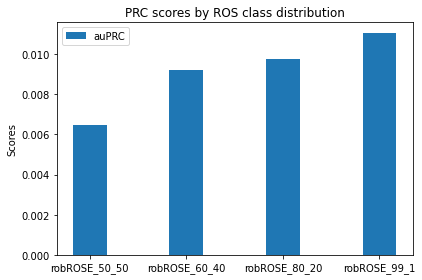

In [30]:
import matplotlib.pyplot as plt
import numpy as np


labels = results.keys()
auPRC_vals = [scores[0] for scores in results.values()]
auROC_vals = [scores[1] for scores in results.values()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, auPRC_vals, width, label='auPRC')
#rects2 = ax.bar(x + width/2, auROC_vals, width, label='auROC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Scores')
ax.set_title('Mean PRC scores by robROSE class distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

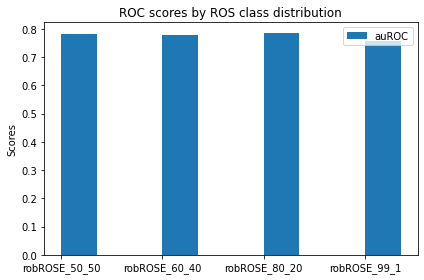

In [31]:
fig, ax = plt.subplots()
#rects1 = ax.bar(x, auPRC_vals, width, label='auPRC')
rects2 = ax.bar(x + width/2, auROC_vals, width, label='auROC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Scores')
ax.set_title('Mean ROC scores by robROSE class distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()